# Imports


In [ ]:
!pip install dateparser
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import json
import csv
import ast
import joblib
import cloudpickle
import requests
import dateparser
import warnings
from datetime import datetime
from bs4 import BeautifulSoup
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import kendalltau
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MultiLabelBinarizer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode

In [ ]:
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message=".*was never awaited.*")
warnings.filterwarnings("ignore", message=".*certificate verification.*")

# Reading CSVs & Merging

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_demo = pd.read_csv('/content/drive/MyDrive/ML DataSet/demos.csv')
df_dlc = pd.read_csv('/content/drive/MyDrive/ML DataSet/dlcs.csv')
df_steam = pd.read_csv('/content/drive/MyDrive/ML DataSet/gamalytic_steam_games.csv')
df_info = pd.read_csv('/content/drive/MyDrive/ML DataSet/info_base_games.csv')

In [ ]:
def merge_game_dataframes(df_info, df_steam, df_dlc, df_demo):

    df_demo.rename(columns={'full_game_appid': 'steam_id'}, inplace=True)
    df_dlc.rename(columns={'base_appid': 'steam_id'}, inplace=True)
    df_steam.rename(columns={'steamId': 'steam_id'}, inplace=True)
    df_info.rename(columns={'appid': 'steam_id'}, inplace=True)

    df_info.rename(columns={'name': 'name_info'}, inplace=True)
    df_dlc.rename(columns={'name': 'name_dlc'}, inplace=True)
    df_demo.rename(columns={'name': 'name_demo'}, inplace=True)

    df_info['steam_id'] = df_info['steam_id'].astype(str)
    df_steam['steam_id'] = df_steam['steam_id'].astype(str)
    df_dlc['steam_id'] = df_dlc['steam_id'].astype(str)
    df_demo['steam_id'] = df_demo['steam_id'].astype(str)

    final_df = pd.merge(df_info, df_steam, on='steam_id', how='outer')
    final_df = pd.merge(final_df, df_dlc[['steam_id', 'dlc_appid', 'name_dlc']], on='steam_id', how='left')
    final_df = pd.merge(final_df, df_demo[['steam_id', 'demo_appid', 'name_demo']], on='steam_id', how='left')

    return final_df

intial_df = merge_game_dataframes(df_info, df_steam, df_dlc, df_demo)

# Dropping Unnecessary columns
intial_df = intial_df.drop('aiContent', axis=1)
#intial_df = intial_df.drop('Unnamed: 0', axis=1)
intial_df = intial_df.drop('name_demo', axis=1)
intial_df = intial_df.drop('name_dlc', axis=1)

**Fetching Data**

In [ ]:
# fetch_pipeline = joblib.load('fetch_pipeline.joblib')
# fetch_df = fetch_pipeline.fit_transform(intial_df)
fetch_df = pd.read_csv('/content/drive/MyDrive/ML DataSet/last.csv')
initial_selected = intial_df[['steam_id', 'copiesSold', 'reviewScore', 'publisherClass']]
fetch_df['steam_id'] = fetch_df['steam_id'].astype(str)
fetch_df = fetch_df.merge(initial_selected, on='steam_id', how='left')

In [ ]:
fetch_df = fetch_df.drop('demo_appid', axis=1)
fetch_df = fetch_df.drop('dlc_appid', axis=1)
fetch_df = fetch_df.drop('name_dlc', axis=1)
fetch_df = fetch_df.drop('name_demo', axis=1)

In [ ]:
# Dropping duplicates due to fetching and null copies sold
print(fetch_df.duplicated().sum())
fetch_df.drop_duplicates(inplace=True)

10296


In [ ]:
fetch_df.shape

(118227, 26)

In [ ]:
fetch_df.columns

Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass'],
      dtype='object')

# Splitting the data

In [ ]:
# train(df): 70%, validation(val_df): 15%, test(test_df): 15%
df, temp_df = train_test_split(fetch_df, test_size=0.30, random_state=42, shuffle=True)
# Step 2: Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, shuffle=True)

# Applying the preprocessing pipeline

In [ ]:
# Should be called if Regression only (first function)
def update_coming_soon_inplace(df):
    condition_coming_soon = (df['coming_soon'] == 1) & (df['copiesSold'].isna())
    df.loc[condition_coming_soon & (df['is_free'] == 1), ['price', 'reviewScore', 'recommendations', 'copiesSold']] = 0
    df.loc[condition_coming_soon, ['reviewScore', 'recommendations', 'copiesSold']] = 0
    return df
def drop_copies_sold_na(df):
    df.dropna(subset=['copiesSold'], inplace=True)
    return df
def preprocess_publisher_data(df):
    publisher_class_mapping = {
        0: 'AAA',
        1: 'Indie',
        2: 'AA',
        3: 'Hobbyist',
        4: 'Other'
    }

    valid_class_names = {
        'AAA': 0,
        'Indie': 1,
        'AA': 2,
        'Hobbyist': 3,
        'Other': 4
    }

    if 'publisher' in df.columns and 'publisherClass' in df.columns:
        df['publisherClass'] = df['publisherClass'].fillna(-1)
        if not df.empty:
            df['publisherClass'] = df['publisherClass'].replace(valid_class_names)
            df['publisherClass'] = df['publisherClass'].apply(lambda x: 4 if isinstance(x, str) else x)

    return df
def fill_publisher_class(df):
    if 'publisher' in df.columns and 'publisherClass' in df.columns:
        values_to_fill_mask = (df['publisherClass'] == -1) | (df['publisherClass'].isna())
        publisher_mode_mapping = df[~values_to_fill_mask].groupby('publisher')['publisherClass'].agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ).to_dict()
        mode_for_each_row = df['publisher'].map(publisher_mode_mapping)
        fill_locations = values_to_fill_mask & mode_for_each_row.notna()
        df.loc[fill_locations, 'publisherClass'] = mode_for_each_row[fill_locations]
    if 'developer' in df.columns and 'publisherClass' in df.columns:
        values_to_fill_mask = (df['publisherClass'] == -1) | (df['publisherClass'].isna())
        valid_df = df[~values_to_fill_mask]
        if not valid_df.empty:
            developer_mode_mapping = valid_df.groupby('developer')['publisherClass'].agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
            ).to_dict()
            mode_for_each_row = df['developer'].map(developer_mode_mapping)
            fill_locations = values_to_fill_mask & mode_for_each_row.notna()
            df.loc[fill_locations, 'publisherClass'] = mode_for_each_row[fill_locations]

    if 'publisherClass' in df.columns:
        mode_val = df['publisherClass'].mode()
        if not mode_val.empty:
            df['publisherClass'].fillna(mode_val[0], inplace=True)
            df.loc[df['publisherClass'] == -1, 'publisherClass'] = mode_val[0]
    return df
def is_missing_price(series):
    mask = series.isna()
    if pd.api.types.is_string_dtype(series):
        mask = mask | (series == '') | (series.str.strip() == '')
    return mask

def fill_price_hierarchically_inplace(df):
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')

    if {'price', 'publisher'}.issubset(df.columns):
        initial_mask = is_missing_price(df['price'])
        valid_df = df[~is_missing_price(df['price']) & ~is_missing_price(df['publisher'])]
        publisher_means = valid_df.groupby('publisher')['price'].mean().to_dict()
        mapped_publisher_mean = df['publisher'].map(publisher_means)
        fill_mask = initial_mask & df['publisher'].notna() & mapped_publisher_mean.notna()
        df.loc[fill_mask, 'price'] = mapped_publisher_mean[fill_mask]

    if {'price', 'developer'}.issubset(df.columns):
        remaining_mask = is_missing_price(df['price'])
        valid_df = df[~is_missing_price(df['price']) & ~is_missing_price(df['developer'])]
        developer_means = valid_df.groupby('developer')['price'].mean().to_dict()
        mapped_dev_mean = df['developer'].map(developer_means)
        fill_mask = remaining_mask & df['developer'].notna() & mapped_dev_mean.notna()
        df.loc[fill_mask, 'price'] = mapped_dev_mean[fill_mask]

    df['price'].fillna(df['price'].mean(), inplace=True)
    return df
def translate_genres(df):
    genre_translation = {
        'Acción': 'Action', 'Ação': 'Action', 'アクション': 'Action', 'Экшены': 'Action',
        'Aventura': 'Adventure', 'Приключенческие игры': 'Adventure', 'アドベンチャー': 'Adventure',
        'Casual': 'Casual', 'Казуальные игры': 'Casual', 'カジュアル': 'Casual', 'Indépendant': 'Indie',
        'Инди': 'Indie', 'インディー': 'Indie', 'Simuladores': 'Simulation', 'シミュレーション': 'Simulation',
        'Stratégie': 'Strategy', 'Estrategia': 'Strategy', 'Strategie': 'Strategy', 'Sport': 'Sports',
        'Course automobile': 'Racing', 'Бесплатные': 'Free To Play', 'Grátis para Jogar': 'Free To Play',
        '無料プレイ': 'Free To Play', 'Accès anticipé': 'Early Access', 'Ранний доступ': 'Early Access',
        '早期アクセス': 'Early Access', 'Ролевые игры': 'RPG', 'Violent': 'Violent', 'Gore': 'Gore',
        'Nudity': 'Nudity', 'Sexual Content': 'Sexual Content', 'MM（Massively Multiplayer）': 'Massively Multiplayer',
        '액션': 'Action', 'Бесплатные': 'Free To Play', 'Ролевые игры': 'RPG', 'Экшены': 'Action', 'Tutorial': 'Software Training',
        'Documentary': 'Education', 'Short': 'Creative Tools', 'Movie': 'Creative Tools'
    }

    if 'genres' in df.columns:
        def safe_translate(genre):
            if pd.isna(genre) or not isinstance(genre, str):
                return 'Unknown'

            try:
                base_genre = genre.split('（')[0].strip().replace('）', '')
                return genre_translation.get(base_genre, genre)
            except (AttributeError, TypeError):
                return genre

        df['genres'] = df['genres'].apply(safe_translate)
    else:
        df['genres'] = 'Unknown'

    return df
import pandas as pd
import numpy as np

def is_missing_or_unknown_genre(series):
    mask = series.isna()
    if pd.api.types.is_string_dtype(series):
        mask = mask | (series == '') | (series.str.strip() == '')
        mask = mask | (series.str.lower() == 'unknown')
    if series.apply(lambda x: isinstance(x, list)).any():
        mask = mask | series.apply(lambda x: isinstance(x, list) and len(x) == 0)
    return mask

def fill_missing_genres(df):

    df = df.copy()

    required_cols = ['genres', 'publisher']
    if all(col in df.columns for col in required_cols):
        initial_genres_to_fill_mask = is_missing_or_unknown_genre(df['genres'])
        valid_genres_for_publisher_mode = df[~is_missing_or_unknown_genre(df['genres'])]

        publisher_mode_mapping = {}
        if not valid_genres_for_publisher_mode.empty:
            valid_publishers_df = valid_genres_for_publisher_mode[~is_missing_or_unknown_genre(valid_genres_for_publisher_mode['publisher'])]
            if not valid_publishers_df.empty:
                publisher_mode_mapping = valid_publishers_df.groupby('publisher')['genres'].agg(
                    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
                ).to_dict()

        publisher_mode_for_each_row = df['publisher'].map(publisher_mode_mapping)
        fill_with_publisher_mask = initial_genres_to_fill_mask & ~is_missing_or_unknown_genre(df['publisher']) & publisher_mode_for_each_row.notna()
        df.loc[fill_with_publisher_mask, 'genres'] = publisher_mode_for_each_row[fill_with_publisher_mask]
    required_cols = ['genres', 'developer']
    if all(col in df.columns for col in required_cols):
        remaining_genres_to_fill_mask = is_missing_or_unknown_genre(df['genres'])
        valid_genres_for_developer_mode = df[~is_missing_or_unknown_genre(df['genres'])]

        developer_mode_mapping = {}
        if not valid_genres_for_developer_mode.empty:
            valid_developers_df = valid_genres_for_developer_mode[~is_missing_or_unknown_genre(valid_genres_for_developer_mode['developer'])]
            if not valid_developers_df.empty:
                developer_mode_mapping = valid_developers_df.groupby('developer')['genres'].agg(
                    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
                ).to_dict()

        developer_mode_for_each_row = df['developer'].map(developer_mode_mapping)
        fill_with_developer_mask = remaining_genres_to_fill_mask & ~is_missing_or_unknown_genre(df['developer']) & developer_mode_for_each_row.notna()
        df.loc[fill_with_developer_mask, 'genres'] = developer_mode_for_each_row[fill_with_developer_mask]
    if 'genres' in df.columns:
        final_remaining_genres_to_fill_mask = is_missing_or_unknown_genre(df['genres'])
        all_valid_genres = df[~is_missing_or_unknown_genre(df['genres'])]
        global_mode_genre = np.nan

        if not all_valid_genres.empty:
            global_mode_genre = all_valid_genres['genres'].mode().iloc[0]

        if pd.notna(global_mode_genre):
            df.loc[final_remaining_genres_to_fill_mask, 'genres'] = global_mode_genre

    return df
def standardize_date(date_str):
    coming_soon_phrases = ['to be announced', 'coming soon', 'maybe', 'em breve', 'binnenkort verwacht']
    if any(phrase in str(date_str).lower() for phrase in coming_soon_phrases):
        return (None, 1)

    quarter_match = re.match(r'Q([1-4])\s*(\d{4})', str(date_str), re.IGNORECASE)
    if quarter_match:
        quarter = int(quarter_match.group(1))
        year = int(quarter_match.group(2))
        month = (quarter - 1) * 3 + 1
        return (f"{year}-{month:02d}-01", 0)

    if re.fullmatch(r'\d{4}', str(date_str)):
        return (f"{date_str}-01-01", 0)

    parsed_date = dateparser.parse(
        str(date_str),
        languages=['en', 'ru', 'fr', 'es', 'zh', 'ko', 'de', 'nl', 'pt'],
        settings={'PREFER_DAY_OF_MONTH': 'first'}
    )

    if parsed_date:
        return (parsed_date.strftime("%Y-%m-%d"), 0)
    else:
        return (None, 1)

def apply_standardize_dates(df):
    df[['standardized_date', 'coming_soon']] = df['release_date'].apply(
        lambda x: pd.Series(standardize_date(x))
    )
    return df
def categorize_genre(genre, category_map, default='Uncategorized'):

    for category, subcategories in category_map.items():
        if genre in subcategories:
            return category
    return default

def update_genres_with_categories(df):

    category_map = {
        'Core Games': ['Action', 'Adventure', 'RPG', 'Strategy', 'Simulation', 'Episodic'],
        'Casual & Social Games': [
            'Casual', 'Free To Play', 'Massively Multiplayer', 'Early Access', 'MM（Massively Multiplayer）'
        ],
        'Sports & Racing': ['Sports', 'Racing'],
        'Indie': ['Indie'],
        'Education & Training': ['Education', 'Software Training', 'Documentary', 'Tutorial'],
        'Creative Tools': [
            'Animation & Modeling', 'Design & Illustration', 'Photo Editing',
            'Video Production', 'Audio Production', 'Web Publishing',
            'Game Development', 'Short', 'Movie'
        ],
        'Productivity Tools': ['Utilities', 'Accounting'],
        'Mature Content': ['Violent', 'Gore', 'Nudity', 'Sexual Content']
    }

    exploded_genres = (
        df['genres']
        .str.split(r',\s*')
        .explode()
        .str.strip()
        .str.replace(r'[（）]', '', regex=True)
        .to_frame()
        .reset_index()
    )
    exploded_genres['category'] = exploded_genres['genres'].apply(
        lambda g: categorize_genre(g, category_map=category_map)
    )
    df = df.join(
        exploded_genres.groupby('index')['category']
        .agg(lambda x: list(set(x)))
        .rename('categories')
    )

    return df
def count_total_languages(language_str):
    if pd.isna(language_str) or language_str == "No info":
        return 1
    languages = [lang.strip() for lang in language_str.split(',') if lang.strip()]
    return len(languages) if languages else 1

def add_total_languages_column(df):
    df['total_languages'] = df['languages_clean_str'].apply(count_total_languages)
    return df
def force_list(x):
    if isinstance(x, (list, tuple, set)):
        return list(x)
    else:
        return []

def MultiLabelBinarizer_encode_categories(df):
    df['categories'] = df['categories'].apply(force_list)
    mlb = MultiLabelBinarizer()
    onehot = mlb.fit_transform(df['categories'])
    onehot_df = pd.DataFrame(onehot, columns=mlb.classes_, index=df.index)
    df = pd.concat([df, onehot_df], axis=1)
    return df
def replace_age_rating(df):
    df['age_rating'].replace('m', 17, inplace=True)
    df['age_rating'].replace('z', 18, inplace=True)
    df['age_rating'].replace('stats', 1, inplace=True)
    df['age_rating'].replace('ec',3, inplace=True)
    df['age_rating'].replace('b', 12, inplace=True)
    df['age_rating'].replace('ao', 18, inplace=True)
    df['age_rating'].replace('c', 15, inplace=True)
    df['age_rating'].replace('rpm', 14, inplace=True)
    df['age_rating'].replace('rp', 17, inplace=True)
    df['age_rating'].replace('d', 17, inplace=True)
    df['age_rating'].replace('e', 6, inplace=True)
    df['age_rating'].replace('a', 1, inplace=True)
    df['age_rating'].replace('e10', 10, inplace=True)
    df['age_rating'].replace('t', 13, inplace=True)
    df['age_rating'] = pd.to_numeric(df['age_rating'], errors='coerce')
    return df
def encode_supported_platforms(df):

    df['supported_platforms'] = df['supported_platforms'].apply(
        lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else
                 (x if isinstance(x, list) else [])
    )

    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df['supported_platforms'])

    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    encoded_df.columns = ['support_' + col.lower() for col in encoded_df.columns]
    result_df = pd.concat([df, encoded_df], axis=1)

    return result_df
def booleans_encoding(df):

    boolean_features = [
        'steam_achievements',
        'steam_trading_cards',
        'workshop_support'
    ]
    for feature in boolean_features:
        if feature in df.columns:
            df[feature] = df[feature].map({True: 1, False: 0}).fillna(-1)
    df['has_demo'] = df[['demo_appid', 'name_demo']].notna().any(axis=1).astype(int)
    df['has_dlc'] = df[['dlc_appid', 'name_dlc']].notna().any(axis=1).astype(int)
    df['has_demo'] = df['has_demo'].fillna(0).astype(int)
    df['has_dlc'] = df['has_dlc'].fillna(0).astype(int)

    return df

In [ ]:
pipeline = Pipeline([
        ('update_coming_soon_inplace', FunctionTransformer(update_coming_soon_inplace, validate=False)),
        ('drop_copies_sold_na', FunctionTransformer(drop_copies_sold_na, validate=False)),
        ('preprocess_publisher_data', FunctionTransformer(preprocess_publisher_data, validate=False)),
        ('fill_publisher_class', FunctionTransformer(fill_publisher_class, validate=False)),
        ('fill_price_hierarchically_inplace', FunctionTransformer(fill_price_hierarchically_inplace, validate=False)),
        ('translate_genres', FunctionTransformer(translate_genres, validate=False)),
        ('fill_missing_genres', FunctionTransformer(fill_missing_genres, validate=False)),
        ('apply_standardize_dates', FunctionTransformer(apply_standardize_dates, validate=False)),
        ('update_genres_with_categories', FunctionTransformer(update_genres_with_categories, validate=False)),
        ('add_total_languages_column', FunctionTransformer(add_total_languages_column, validate=False)),
        ('MultiLabelBinarizer_encode_categories', FunctionTransformer(MultiLabelBinarizer_encode_categories, validate=False)),
        ('replace_age_rating', FunctionTransformer(replace_age_rating, validate=False)),
        #('encode_platforms', FunctionTransformer(encode_supported_platforms, validate=False)),
        #('booleans_encoding', FunctionTransformer(booleans_encoding, validate=False))
])
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [ ]:
pipeline = joblib.load('pipeline.joblib')
df = pipeline.fit_transform(df)

In [ ]:
df.columns


Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass', 'standardized_date', 'categories',
       'total_languages', 'Casual & Social Games', 'Core Games',
       'Creative Tools', 'Education & Training', 'Indie', 'Mature Content',
       'Productivity Tools', 'Sports & Racing', 'Uncategorized'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   steam_id               78101 non-null  object 
 1   name_info              78086 non-null  object 
 2   metacritic             78101 non-null  int64  
 3   steam_achievements     78101 non-null  int64  
 4   steam_trading_cards    78101 non-null  int64  
 5   workshop_support       78101 non-null  int64  
 6   genres                 78101 non-null  object 
 7   achievements_total     78101 non-null  int64  
 8   release_date           77953 non-null  object 
 9   coming_soon            78101 non-null  float64
 10  support_windows        78101 non-null  int64  
 11  support_mac            78101 non-null  int64  
 12  support_linux          78101 non-null  int64  
 13  has_dlc                78101 non-null  int64  
 14  has_demo               78101 non-null  int64  
 15  pub

# EDA

In [ ]:
# Shows that the developer and publisher columns
# Have significant effect on the publisherClass
# According to chi squared metric

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

def simple_publisher_analysis(df):
    binary_cols = ['steam_achievements', 'steam_trading_cards', 'workshop_support',
                   'controller_support', 'has_dlc', 'has_demo']
    cat_cols = ['developer', 'age_rating', 'publisher']
    num_cols = ['price']

    if 'publisherClass' not in df.columns:
        print("Error: 'publisherClass' column not found in dataframe")
        return

    print(f"{'Column':<20} {'Kendall Tau':<12} {'K p-value':<12} {'Test Type':<12} {'Statistic':<12} {'p-value':<12}")
    print("-" * 80)

    for col in binary_cols + cat_cols + num_cols:
        if col not in df.columns:
            print(f"{col:<20} Not in dataframe")
            continue

        valid_data = df[['publisherClass', col]].dropna()
        if len(valid_data) == 0:
            print(f"{col:<20} No valid data")
            continue

        try:
            col_data = valid_data[col]
            if col in cat_cols:
                col_data = pd.factorize(col_data)[0]
            tau, k_pval = stats.kendalltau(valid_data['publisherClass'], col_data)
            k_result = f"{tau:.4f}", f"{k_pval:.4f}"
        except:
            k_result = "Error", "Error"

        try:
            if col in binary_cols or col in num_cols:
                groups = []
                for class_val in df['publisherClass'].unique():
                    group = df[df['publisherClass'] == class_val][col].dropna()
                    if len(group) > 0:
                        groups.append(group)
                if len(groups) >= 2:
                    f_val, t_pval = stats.f_oneway(*groups)
                    test_type = "ANOVA"
                    test_result = f"{f_val:.4f}", f"{t_pval:.4f}"
                else:
                    test_type, test_result = "ANOVA", ("N/A", "N/A")
            else:
                table = pd.crosstab(df['publisherClass'], df[col])
                chi2, t_pval, _, _ = chi2_contingency(table)
                test_type = "Chi2"
                test_result = f"{chi2:.4f}", f"{t_pval:.4f}"
        except:
            test_type, test_result = "Error", ("Error", "Error")

        if col in ['developer', 'publisher']:
            highlight_start = "\033[1;33m"
            highlight_end = "\033[0m"
        else:
            highlight_start = ""
            highlight_end = ""

        print(f"{highlight_start}{col:<20} {k_result[0]:<12} {k_result[1]:<12} {test_type:<12} {test_result[0]:<12} {test_result[1]:<12}{highlight_end}")
simple_publisher_analysis(fetch_df) # change the df

Column               Kendall Tau  K p-value    Test Type    Statistic    p-value     
--------------------------------------------------------------------------------
steam_achievements   0.1523       0.0000       ANOVA        1471.1973    0.0000      
steam_trading_cards  0.1801       0.0000       ANOVA        3943.5470    0.0000      
workshop_support     0.0299       0.0000       ANOVA        261.3961     0.0000      
controller_support   0.0196       0.0000       ANOVA        432.9969     0.0000      
has_dlc              0.1252       0.0000       ANOVA        2281.0962    0.0000      
has_demo             0.0148       0.0000       ANOVA        8.4389       0.0000      
developer            -0.2459      0.0000       Chi2         241256.1392  0.0000      
age_rating           0.0116       0.0001       Chi2         7730.9496    0.0000      
publisher            -0.2726      0.0000       Chi2         271317.0353  0.0000      
price                0.1647       0.0000       ANOVA       

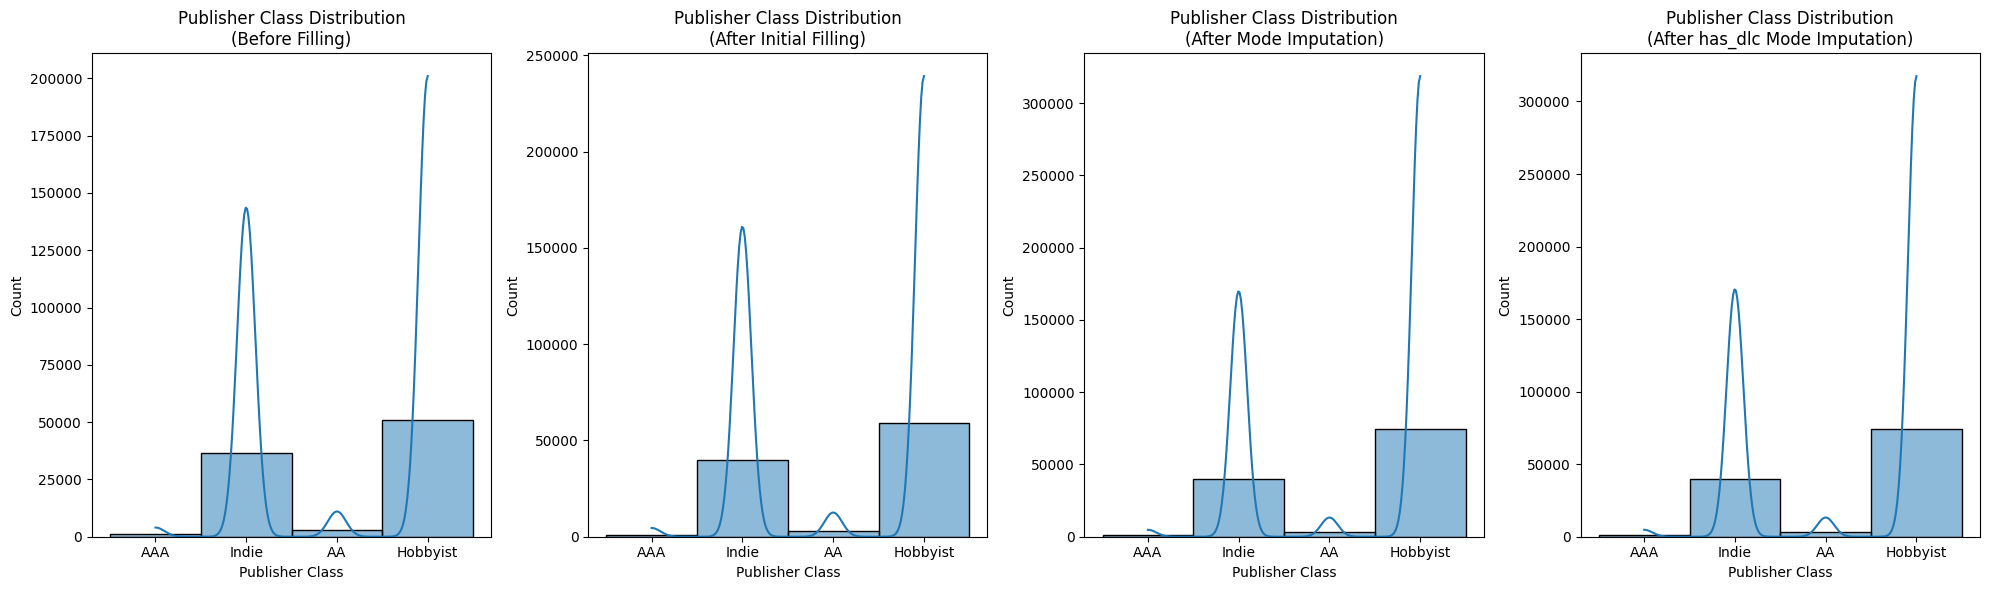

In [ ]:
# PublisherClass distribution after different imputations technique
def fill_publisher_class(df):
    if 'publisher' in df.columns and 'publisherClass' in df.columns:
        values_to_fill_mask = (df['publisherClass'] == -1) | (df['publisherClass'].isna())
        publisher_mode_mapping = df[~values_to_fill_mask].groupby('publisher')['publisherClass'].agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ).to_dict()
        mode_for_each_row = df['publisher'].map(publisher_mode_mapping)
        fill_locations = values_to_fill_mask & mode_for_each_row.notna()
        df.loc[fill_locations, 'publisherClass'] = mode_for_each_row[fill_locations]
    elif 'developer' in df.columns and 'publisherClass' in df.columns:
        values_to_fill_mask = (df['publisherClass'] == -1) | (df['publisherClass'].isna())
        valid_df = df[~values_to_fill_mask]
        if not valid_df.empty:
            developer_mode_mapping = valid_df.groupby('developer')['publisherClass'].agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
            ).to_dict()
            mode_for_each_row = df['developer'].map(developer_mode_mapping)
            fill_locations = values_to_fill_mask & mode_for_each_row.notna()
            df.loc[fill_locations, 'publisherClass'] = mode_for_each_row[fill_locations]
    else:
        if 'publisherClass' in df.columns:
            mode_val = df['publisherClass'].mode()
            if not mode_val.empty:
                df['publisherClass'].fillna(mode_val[0], inplace=True)
    return df
def analyze_publisher_distributions(df):

    df_original = df.copy()

    pre_fill_data = df_original['publisherClass'].copy()

    df_filled = fill_publisher_class(df_original.copy())

    after_initial_fill = df_filled['publisherClass'].copy()

    df_mode_filled = df_filled.copy()

    mode_value = df_filled['publisherClass'].mode()[0]
    df_mode_filled['publisherClass'] = df_mode_filled['publisherClass'].replace(-1, mode_value)
    df_mode_filled['publisherClass'] = df_mode_filled['publisherClass'].fillna(mode_value)

    df_dlc_filled = df_filled.copy()

    if 'has_dlc' in df_dlc_filled.columns:

        dlc_modes = df_dlc_filled.groupby('has_dlc')['publisherClass'].apply(
            lambda x: x.mode()[0] if not x.mode().empty else mode_value)

        for dlc_val in dlc_modes.index:
            group_mode = dlc_modes[dlc_val]

            mask_null = (df_dlc_filled['has_dlc'] == dlc_val) & (df_dlc_filled['publisherClass'].isna())
            df_dlc_filled.loc[mask_null, 'publisherClass'] = group_mode

            mask_neg = (df_dlc_filled['has_dlc'] == dlc_val) & (df_dlc_filled['publisherClass'] == -1)
            df_dlc_filled.loc[mask_neg, 'publisherClass'] = group_mode
    else:
        df_dlc_filled = df_mode_filled.copy()

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 4, 1)
    sns.histplot(pre_fill_data.dropna(), kde=True)
    plt.title("Publisher Class Distribution\n(Before Filling)")
    plt.xlabel("Publisher Class")

    plt.subplot(1, 4, 2)
    sns.histplot(after_initial_fill.dropna(), kde=True)
    plt.title("Publisher Class Distribution\n(After Initial Filling)")
    plt.xlabel("Publisher Class")

    plt.subplot(1, 4, 3)
    sns.histplot(df_mode_filled['publisherClass'], kde=True)
    plt.title("Publisher Class Distribution\n(After Mode Imputation)")
    plt.xlabel("Publisher Class")

    plt.subplot(1, 4, 4)
    sns.histplot(df_dlc_filled['publisherClass'], kde=True)
    plt.title("Publisher Class Distribution\n(After has_dlc Mode Imputation)")
    plt.xlabel("Publisher Class")

    plt.tight_layout()
    plt.show()

    del df_original
    del df_filled
    del df_mode_filled
    del df_dlc_filled
    del after_initial_fill
    del pre_fill_data

analyze_publisher_distributions(fetch_df)  # change the df


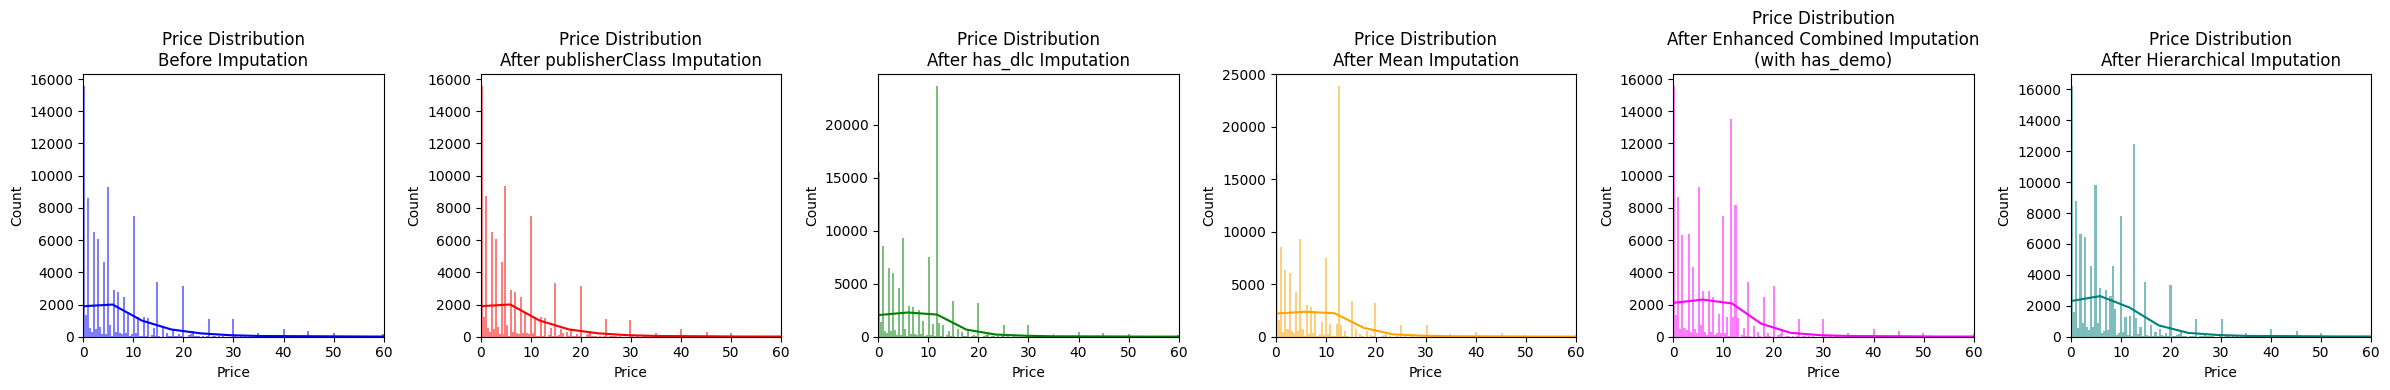

In [ ]:
def plot_price_imputation_methods(df):

    df_original = df.copy()

    original_price = df_original['price'].copy()

    before_imputation = original_price.copy()

    df_has_dlc = df_original.copy()
    df_publisher_class = df_original.copy()
    df_mean = df_original.copy()
    df_hierarchical = df_original.copy()
    df_combined_enhanced = df_original.copy()

    if 'has_dlc' in df.columns:

        has_dlc_means = df_has_dlc.groupby('has_dlc')['price'].transform('mean')

        price_nulls = df_has_dlc['price'].isna()
        df_has_dlc.loc[price_nulls, 'price'] = has_dlc_means[price_nulls]
    else:
        print("Warning: has_dlc column not found")

    if 'publisherClass' in df.columns:

        pub_class_means = df_publisher_class.groupby('publisherClass')['price'].transform('mean')

        price_nulls = df_publisher_class['price'].isna()
        df_publisher_class.loc[price_nulls, 'price'] = pub_class_means[price_nulls]
    else:
        print("Warning: publisherClass column not found")

    overall_mean = df_mean['price'].mean()
    df_mean['price'].fillna(overall_mean, inplace=True)

    df_hierarchical = fill_price_hierarchically_inplace(df_hierarchical)

    required_cols = ['publisherClass', 'has_dlc', 'has_demo']
    if all(col in df.columns for col in required_cols):

        price_nulls = df_combined_enhanced['price'].isna()
        null_indices = df_combined_enhanced[price_nulls].index

        if len(null_indices) > 0:

            pub_class_means = df_combined_enhanced.groupby('publisherClass')['price'].mean().to_dict()
            has_dlc_means = df_combined_enhanced.groupby('has_dlc')['price'].mean().to_dict()
            has_demo_means = df_combined_enhanced.groupby('has_demo')['price'].mean().to_dict()

            np.random.seed(42)

            for idx in null_indices:

                row_pub_class = df_combined_enhanced.loc[idx, 'publisherClass']
                row_has_dlc = df_combined_enhanced.loc[idx, 'has_dlc']
                row_has_demo = df_combined_enhanced.loc[idx, 'has_demo']

                if pd.isna(row_pub_class) or row_pub_class not in pub_class_means:
                    pub_class_price = df_combined_enhanced['price'].mean()
                else:
                    pub_class_price = pub_class_means[row_pub_class]

                if pd.isna(row_has_dlc) or row_has_dlc not in has_dlc_means:
                    has_dlc_price = df_combined_enhanced['price'].mean()
                else:
                    has_dlc_price = has_dlc_means[row_has_dlc]

                if pd.isna(row_has_demo) or row_has_demo not in has_demo_means:
                    has_demo_price = df_combined_enhanced['price'].mean()
                else:
                    has_demo_price = has_demo_means[row_has_demo]

                choices = [pub_class_price, has_dlc_price, has_demo_price]
                weights = [0.35, 0.25, 0.4]
                selected_price = np.random.choice(choices, p=weights)

                df_combined_enhanced.loc[idx, 'price'] = selected_price
    else:
        print("Warning: Not all required columns present for enhanced combined approach")

        df_combined_enhanced['price'].fillna(df_combined_enhanced['price'].mean(), inplace=True)

    plt.figure(figsize=(24, 4))

    plt.subplot(1, 6, 1)
    sns.histplot(before_imputation.dropna(), kde=True, color='blue')
    plt.title("Price Distribution\nBefore Imputation")
    plt.xlabel("Price")
    plt.xlim(0, 60)

    plt.subplot(1, 6, 2)
    sns.histplot(df_publisher_class['price'], kde=True, color='red')
    plt.title("Price Distribution\nAfter publisherClass Imputation")
    plt.xlabel("Price")
    plt.xlim(0, 60)

    plt.subplot(1, 6, 3)
    sns.histplot(df_has_dlc['price'], kde=True, color='green')
    plt.title("Price Distribution\nAfter has_dlc Imputation")
    plt.xlabel("Price")
    plt.xlim(0, 60)

    plt.subplot(1, 6, 4)
    sns.histplot(df_mean['price'], kde=True, color='orange')
    plt.title("Price Distribution\nAfter Mean Imputation")
    plt.xlabel("Price")
    plt.xlim(0, 60)

    plt.subplot(1, 6, 5)
    sns.histplot(df_combined_enhanced['price'], kde=True, color='magenta')
    plt.title("Price Distribution\nAfter Enhanced Combined Imputation\n(with has_demo)")
    plt.xlabel("Price")
    plt.xlim(0, 60)

    plt.subplot(1, 6, 6)
    sns.histplot(df_hierarchical['price'], kde=True, color='teal')
    plt.title("Price Distribution\nAfter Hierarchical Imputation")
    plt.xlabel("Price")
    plt.xlim(0, 60)

    plt.tight_layout()
    plt.show()

    del df_original
    del df_publisher_class
    del df_has_dlc
    del df_mean
    del df_combined_enhanced
    del df_hierarchical

plot_price_imputation_methods(fetch_df)

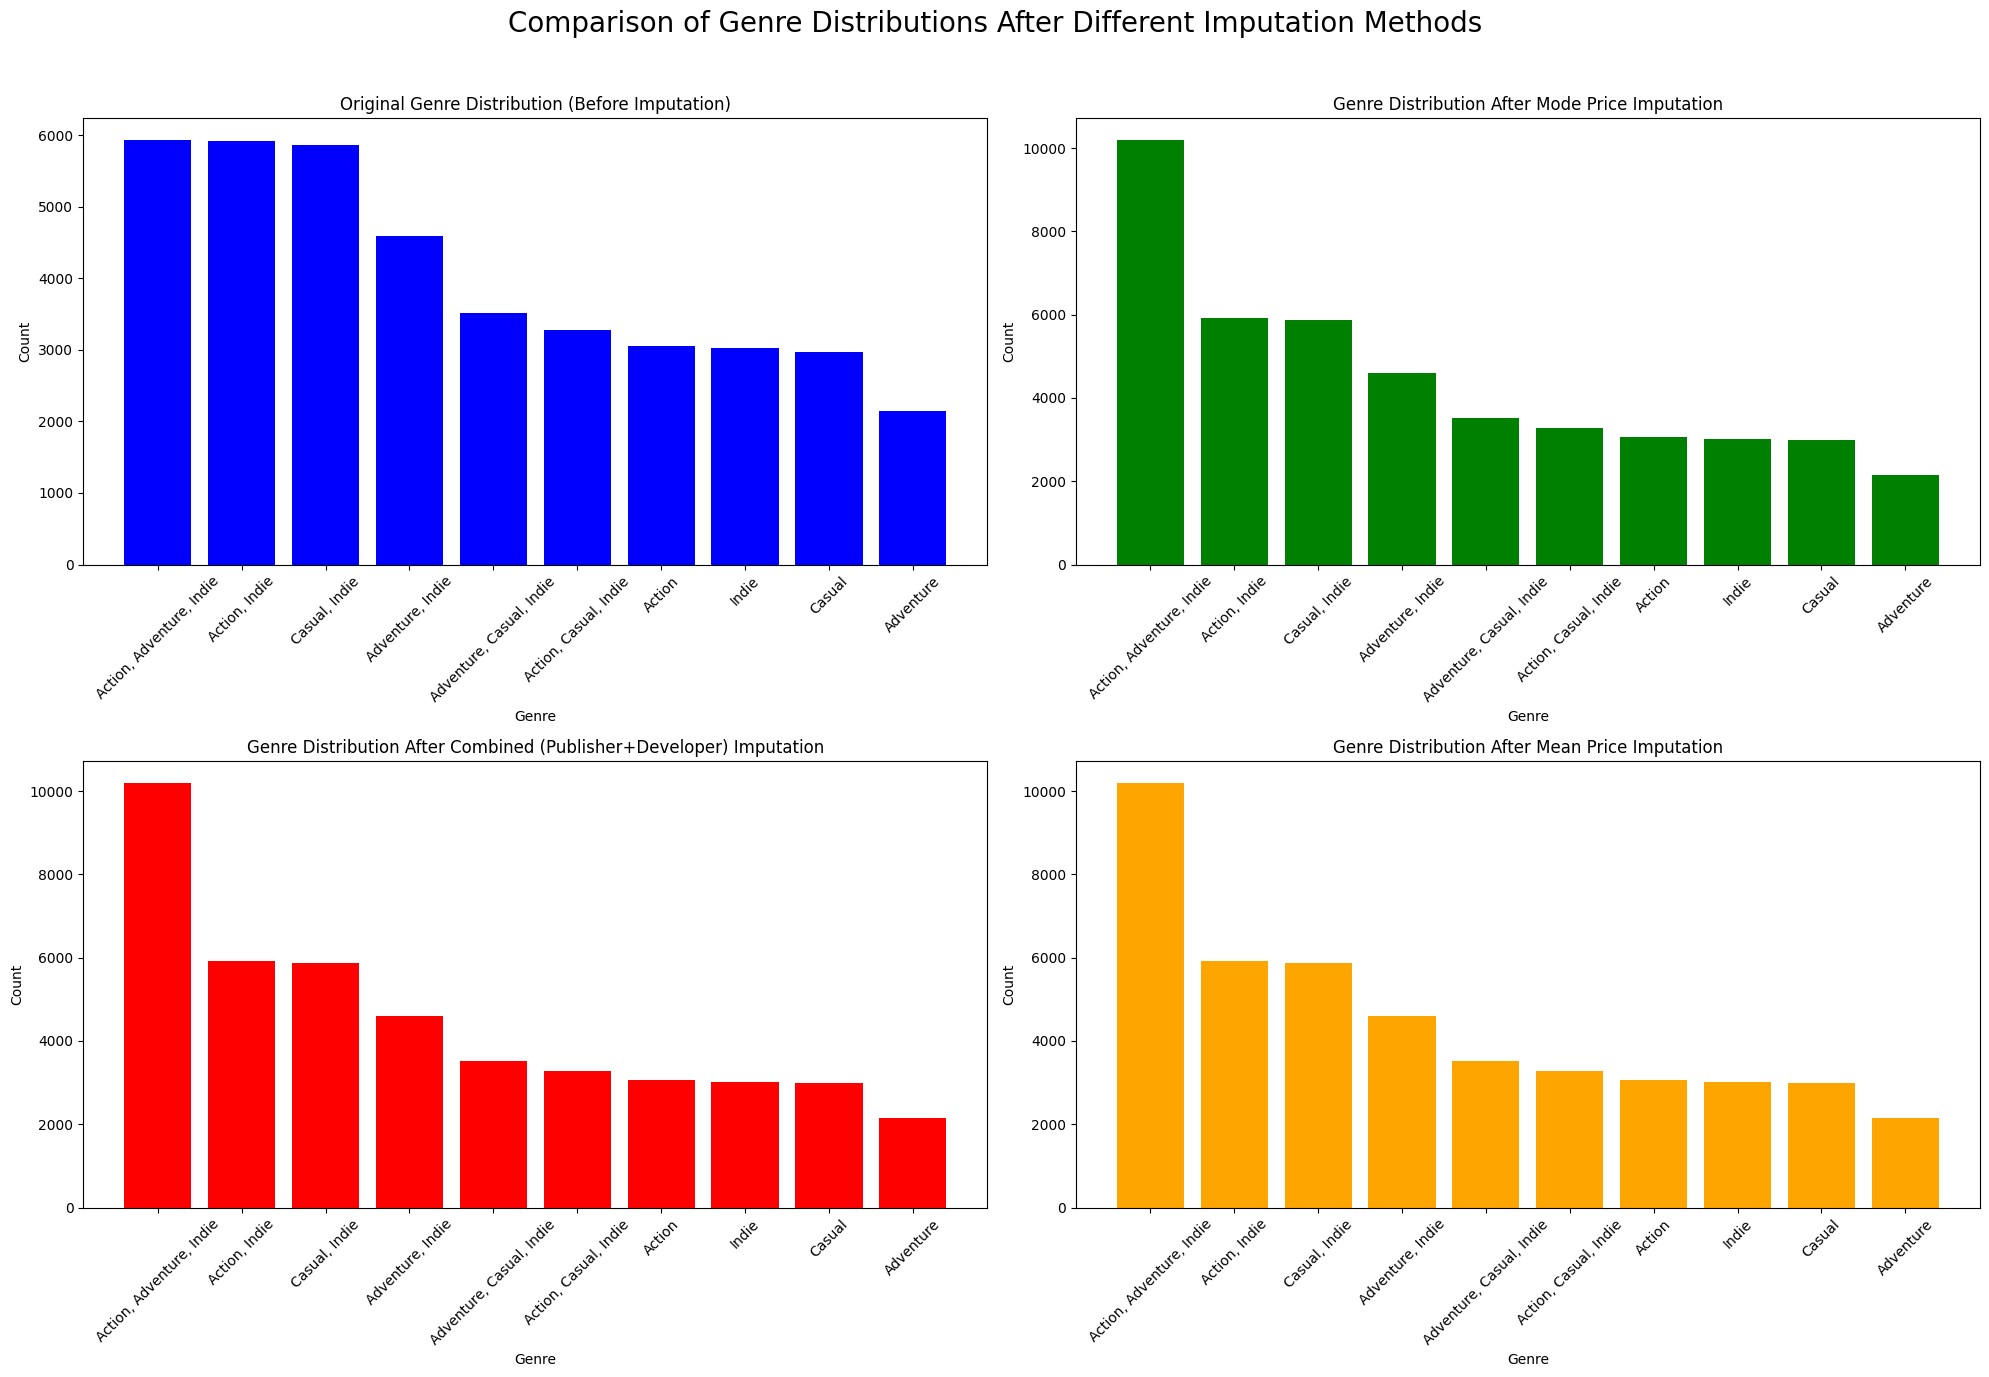

Change in genre counts after imputation:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_genre_imputation_comparison(df):

    df_original = df.copy()
    df_mode = df.copy()
    df_combined = df.copy()
    df_mean = df.copy()

    original_genres = df_original['genres'].copy()

    def get_genre_distribution(series):

        genre_counts = Counter(series.dropna())

        sorted_genres = dict(sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10])
        return sorted_genres

    original_distribution = get_genre_distribution(original_genres)

    price_mode = df_mode['price'].mode().iloc[0]
    price_null_mask = df_mode['price'].isna()
    df_mode.loc[price_null_mask, 'price'] = price_mode

    df_mode = fill_missing_genres(df_mode)
    mode_distribution = get_genre_distribution(df_mode['genres'])

    df_combined = fill_missing_genres(df_combined)
    combined_distribution = get_genre_distribution(df_combined['genres'])

    price_mean = df_mean['price'].mean()
    price_null_mask = df_mean['price'].isna()
    df_mean.loc[price_null_mask, 'price'] = price_mean

    df_mean = fill_missing_genres(df_mean)
    mean_distribution = get_genre_distribution(df_mean['genres'])

    fig, axs = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Comparison of Genre Distributions After Different Imputation Methods', fontsize=20)

    axs[0, 0].bar(original_distribution.keys(), original_distribution.values(), color='blue')
    axs[0, 0].set_title('Original Genre Distribution (Before Imputation)')
    axs[0, 0].set_xlabel('Genre')
    axs[0, 0].set_ylabel('Count')
    axs[0, 0].tick_params(axis='x', rotation=45)

    axs[0, 1].bar(mode_distribution.keys(), mode_distribution.values(), color='green')
    axs[0, 1].set_title('Genre Distribution After Mode Price Imputation')
    axs[0, 1].set_xlabel('Genre')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].tick_params(axis='x', rotation=45)

    axs[1, 0].bar(combined_distribution.keys(), combined_distribution.values(), color='red')
    axs[1, 0].set_title('Genre Distribution After Combined (Publisher+Developer) Imputation')
    axs[1, 0].set_xlabel('Genre')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].tick_params(axis='x', rotation=45)

    axs[1, 1].bar(mean_distribution.keys(), mean_distribution.values(), color='orange')
    axs[1, 1].set_title('Genre Distribution After Mean Price Imputation')
    axs[1, 1].set_xlabel('Genre')
    axs[1, 1].set_ylabel('Count')
    axs[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('genre_imputation_comparison.png')
    plt.show()

    print("Change in genre counts after imputation:")

    def calc_percent_change(original, new, method_name):
        all_genres = set(list(original.keys()) + list(new.keys()))
        changes = []

        for genre in all_genres:
            orig_count = original.get(genre, 0)
            new_count = new.get(genre, 0)

            if orig_count == 0:
                pct_change = "New"
            else:
                pct_change = f"{((new_count - orig_count) / orig_count) * 100:.2f}%"

            changes.append((genre, orig_count, new_count, pct_change))

        changes.sort(key=lambda x: abs(x[2] - x[1]) if isinstance(x[1], (int, float)) and isinstance(x[2], (int, float)) else 0, reverse=True)

        print(f"\n{method_name}:")
        print(f"{'Genre':<20} {'Original':<10} {'New':<10} {'% Change':<10}")
        print("-" * 50)

        for genre, orig, new, pct in changes[:10]:
            print(f"{genre:<20} {orig:<10} {new:<10} {pct:<10}")

    del df_original
    del df_mode
    del df_combined
    del df_mean

plot_genre_imputation_comparison(fetch_df)

In [ ]:
# Pie chart showing the distribution of free vs. paid games

free, not_free = df[df['price'] == 0].shape[0], df[df['price'] != 0].shape[0]

labels = ['free', 'not free']

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=[free, not_free])])

fig.update_traces(textinfo='value', textfont_size=20,
                  marker=dict(colors=['salmon', 'lightblue'],
                  line=dict(color='#000000', width=2)))

fig.update_layout(
    height=600, width=600, title_text='Free and not free games',
    xaxis_title='number of songs', yaxis_title='artist', title_x = 0.5,

    font=dict(
            family="Courier New, monospace",
            size=18,
            color="black"),

    legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.2,
            xanchor="right",
            x=0.75)
)

fig.show()

In [ ]:
# Bar chart showing how many games support Windows, Mac, and Linux platforms
# Almost all the games supports windows which indicates less importance of support_windows column

windows = df['support_windows'].sum()
mac = df['support_mac'].sum()
linux = df['support_linux'].sum()

labels = ['Windows', 'Mac', 'Linux']
values = [windows, mac, linux]

fig = go.Figure()

fig.add_trace(go.Bar(x=labels, y=values,
                     marker_color='salmon'))

fig.update_layout(
    height=600, width=500, title_text='Platform Support Frequency',
    xaxis_title='Platform', yaxis_title='Count', title_x=0.5,
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="black"
    )
)

fig.show()

In [ ]:
df['standardized_date'] = pd.to_datetime(df['standardized_date'], errors='coerce')
df['standardized_date']

,standardized_date
16900,2017-08-18
49562,2021-09-23
79093,2023-05-25
48319,2022-09-09
97798,2024-05-05
...,...
77481,2023-04-06
114124,NaT
104403,NaT
861,2010-08-27


In [ ]:
# Bar chart showing the number of Steam games released per year

fig = go.Figure()
fig.add_trace(go.Bar(x = df['standardized_date'].dt.year.value_counts().index[:30],
                     y  = df['standardized_date'].dt.year.value_counts().values[:30],
                     marker_color = 'salmon' ))

fig.update_layout(
    height=600, width=500, title_text='Steam games per year', yaxis_title='count', title_x = 0.5,

    font=dict(
            family="Courier New, monospace",
            size=14,
            color="black")
)

fig.show()

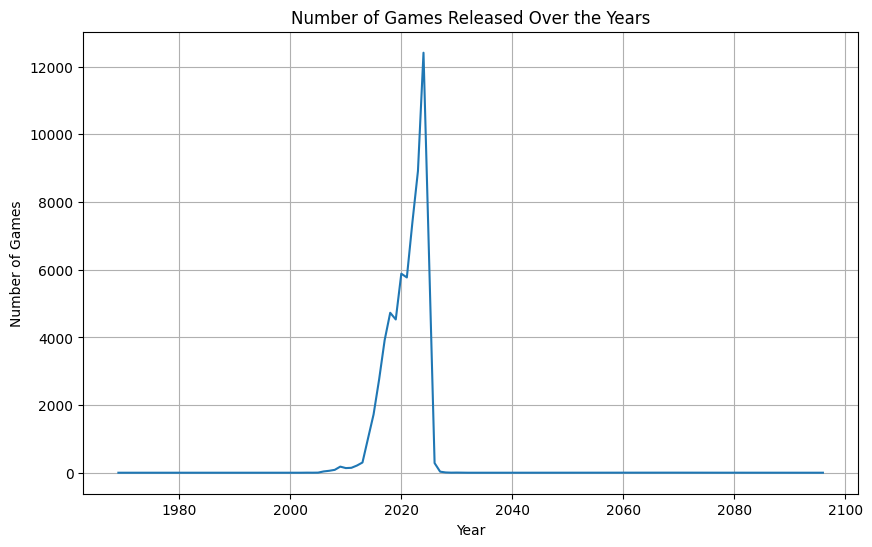

In [ ]:
# Line plot showing the number of games released each year

df['standardized_date'] = df['standardized_date'].dt.year

plt.figure(figsize=(10, 6))
df['standardized_date'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Games Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True)
plt.show()

In [ ]:
# Bar chart showing the top 50 Steam developers by number of game releases

top_10_devs = df['developer'].value_counts().sort_values(ascending=False).head(50)

fig = go.Figure()

fig.add_trace(go.Bar(x=top_10_devs.index, y=top_10_devs.values, marker_color='salmon'))

fig.update_layout(
    height=800, width=600, title_text='TOP 10 STEAM DEVELOPERS', yaxis_title='count', title_x = 0.5,

    font=dict(
            family="Courier New, monospace",
            size=14,
            color="black")
)


fig.show()

In [ ]:
# Bar chart showing the top 25 Steam publishers by number of game releases

top_10_publishers = df['publisher'].value_counts().sort_values(ascending=False).head(25)

fig = go.Figure()

fig.add_trace(go.Bar(x=top_10_publishers.index, y=top_10_publishers.values, marker_color='salmon'))

fig.update_layout(
    height=800, width=600, title_text='TOP 10 STEAM PUBLISHERS', yaxis_title='count', title_x = 0.5,

    font=dict(
            family="Courier New, monospace",
            size=14,
            color="black")
)


fig.show()

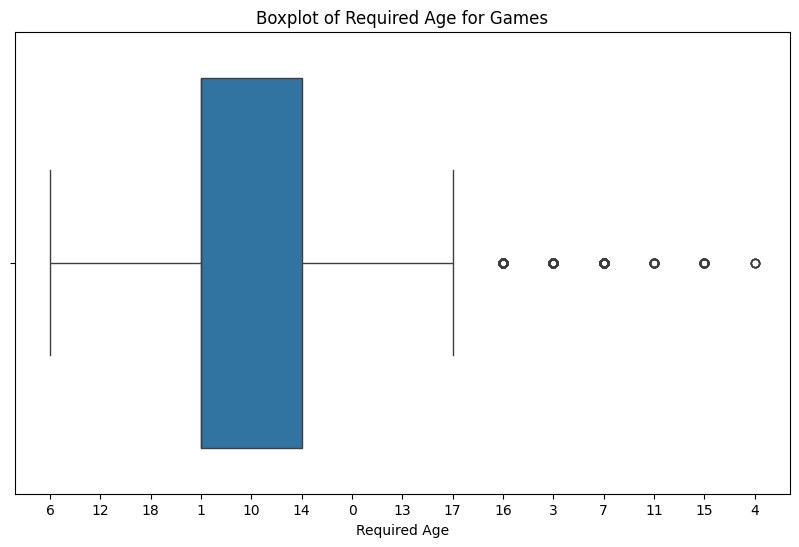

In [ ]:
# Boxplot showing the distribution of age ratings for Steam games

df1 = df.copy()
df1['age_rating'] = df1['age_rating'].astype(str)

plt.figure(figsize=(10, 6))
sns.boxplot(x='age_rating', data=df1)
plt.title('Boxplot of Required Age for Games')
plt.xlabel('Required Age')
plt.show()

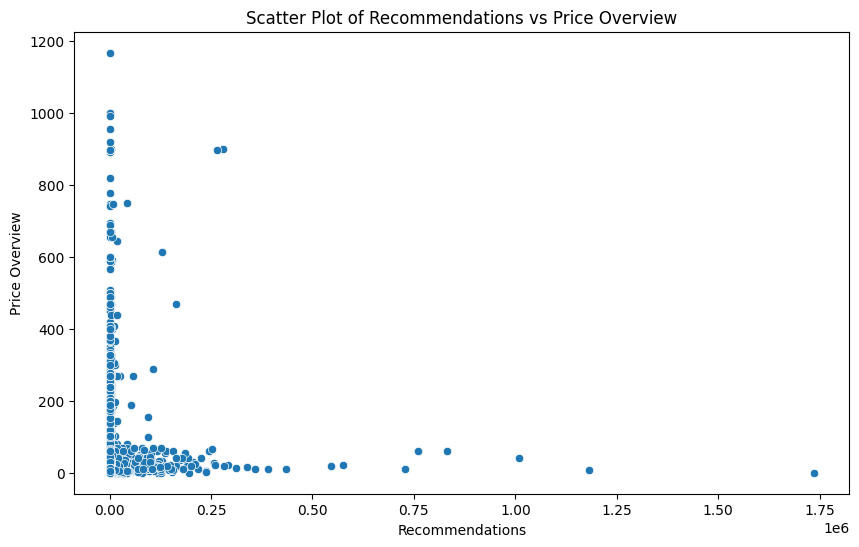

In [ ]:
# Scatter plot to explore the relationship between game recommendations and price

plt.figure(figsize=(10, 6))
sns.scatterplot(x='recommendations', y='price', data=df)
plt.title('Scatter Plot of Recommendations vs Price Overview')
plt.xlabel('Recommendations')
plt.ylabel('Price Overview')
plt.show()

In [ ]:
fetch_df.columns

Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass'],
      dtype='object')

no column called categories changed it to genres


In [ ]:
# Visualizes the number of games per category

fetch_df2 = fetch_df.copy()

def process_categories(categories):
    if isinstance(categories, list):
        return [item.strip().lower() for item in categories]
    elif isinstance(categories, str):
        return [item.strip().lower() for item in categories.split(',')]
    else:
        return []

fetch_df2['genre_splitted'] = fetch_df2['genres'].apply(process_categories) #here only
genre_counts = fetch_df2['genre_splitted'].explode().value_counts()
df2 = pd.DataFrame({'categories': genre_counts.index, 'Number of Games': genre_counts.values})

fig = px.bar(df2, x='categories', y='Number of Games', text='Number of Games', title='Number of Games per Category',
             labels={'Number of Games': 'Number of Games', 'categories': 'Categories'})

fig.update_layout(
    xaxis=dict(
        tickangle=45,
        tickmode='array',
        tickvals=list(range(len(genre_counts.index))),
        ticktext=genre_counts.index
    )
)

fig.show()

In [ ]:
# Horizontal bar chart of the top 10 games by number of recommendations

df['recommendations'] = pd.to_numeric(df['recommendations'], errors='coerce')

print("Max recommendations before filtering:", df['recommendations'].max())
max_recommendations_row = df[df['recommendations'] == df['recommendations'].max()]
print("\nRow with max recommendations:")
print(max_recommendations_row[['name_info', 'recommendations']].to_string(index=False))

filtered_df = df[df['recommendations'] <= 16000000]

top_10_games = filtered_df.nlargest(10, 'recommendations')

fig = px.bar(
    top_10_games,
    x='name_info',
    y='recommendations',
    title='Top 10 Games by Recommendations',
    labels={'recommendations': 'Recommendations', 'name_info': 'Game'},
)
fig.update_layout(xaxis_tickangle=-45, height=600, width=900, title_x=0.5)
fig.update_traces(textposition='outside')
fig.show()

Max recommendations before filtering: 1736660

Row with max recommendations:
          name_info  recommendations
PUBG: BATTLEGROUNDS          1736660


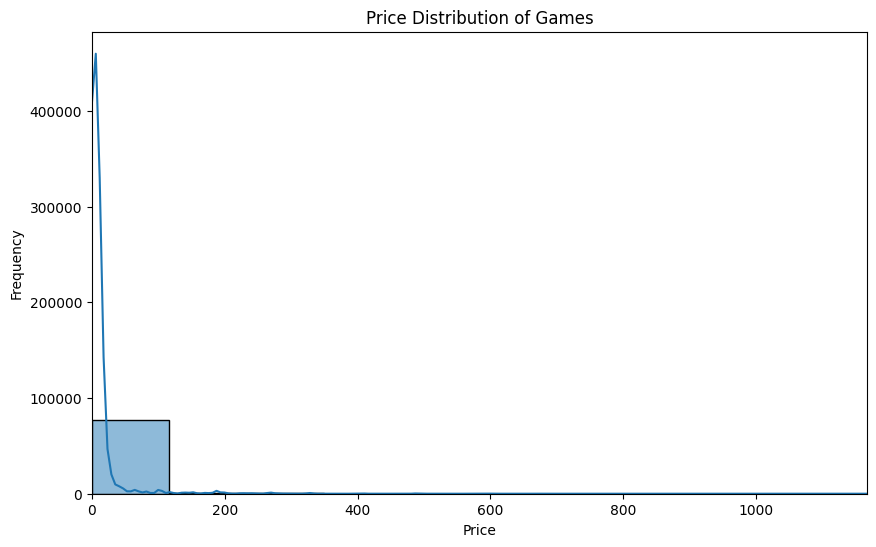

In [ ]:
# Histogram that shows the distribution of game prices

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=10, kde=True)
plt.title("Price Distribution of Games")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.xlim(0, df['price'].max())
plt.show()

In [ ]:
# Convert age_rating to numeric, replacing non-convertible values with NaN
df['age_rating'] = pd.to_numeric(df['age_rating'], errors='coerce')

# Define columns to drop to create feature set X
temp = ['copiesSold','name_info','steam_id','metacritic','achievements_total','developer','publisher','recommendations','age_rating','price','reviewScore','standardized_date','standardized_date','languages_clean_str']
# temp = ['copiesSold','name_info','steam_id','metacritic','achievements_total','developer','publisher','recommendations','age_rating','price','reviewScore','languages_clean_str']
X = df.drop(columns=temp)
y = df['copiesSold']
Xtemp = X.copy()

# Show columns with non-numeric data types
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in X:")
print(non_numeric_cols)
temp = ['copiesSold','name_info','steam_id','metacritic','achievements_total','developer','publisher','recommendations','age_rating','price','reviewScore','languages_clean_str']
X = df.drop(columns=temp)
# Remove non-numeric columns from X
X_numeric = Xtemp.select_dtypes(include=['number'])
print("Using only numeric columns for feature selection.")
# Apply SelectKBest with numeric features only
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_numeric, y)

# Create and sort the scores DataFrame
scores = pd.DataFrame({
    'feature': X_numeric.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('F_score', ascending=False)

print(scores)

Non-numeric columns in X:
Index(['genres', 'release_date', 'categories'], dtype='object')
Using only numeric columns for feature selection.
                  feature     F_score        p_value
1     steam_trading_cards  463.161629  1.959769e-102
2        workshop_support  423.669385   6.895723e-94
7                 has_dlc  389.155381   2.054323e-86
11         publisherClass  286.537551   3.678448e-64
9                 is_free  101.651635   6.846561e-24
17                  Indie   95.919754   1.232839e-22
21          Uncategorized   53.923381   2.104828e-13
12        total_languages   49.181578   2.352180e-12
6           support_linux   42.853550   5.935874e-11
0      steam_achievements   37.864818   7.618724e-10
5             support_mac   36.262968   1.731757e-09
3             coming_soon   29.030364   7.145820e-08
10     controller_support   27.991581   1.221719e-07
14             Core Games   15.583158   7.902384e-05
8                has_demo    7.258293   7.058943e-03
18         M

In [ ]:
# Computes Kendall’s Tau correlation and corresponding p-values between features and 'copiesSold'

taus = []
pvals = []
for col in X.columns:
    mask = X[col].notna() & y.notna()
    if mask.sum() < 2:
        tau, p = 0.0, 1.0
    else:
        tau, p = kendalltau(X.loc[mask, col], y.loc[mask])
    taus.append(tau)
    pvals.append(p)

kendall_df = pd.DataFrame({
    'feature':    X.columns,
    'kendall_tau': taus,
    'p_value':    pvals
})

kendall_df['abs_tau'] = kendall_df['kendall_tau'].abs()
kendall_df = kendall_df.sort_values('abs_tau', ascending=False)
print(kendall_df)

                  feature  kendall_tau        p_value   abs_tau
5             coming_soon    -0.480043   0.000000e+00  0.480043
13         publisherClass    -0.431767   0.000000e+00  0.431767
14      standardized_date    -0.337419   0.000000e+00  0.337419
1     steam_trading_cards     0.324699   0.000000e+00  0.324699
9                 has_dlc     0.290102   0.000000e+00  0.290102
0      steam_achievements     0.177307   0.000000e+00  0.177307
11                is_free     0.176162   0.000000e+00  0.176162
16        total_languages     0.152441   0.000000e+00  0.152441
7             support_mac     0.124881   0.000000e+00  0.124881
10               has_demo    -0.102238  4.264200e-259  0.102238
8           support_linux     0.079868  6.243948e-159  0.079868
2        workshop_support     0.069344  2.652202e-120  0.069344
3                  genres     0.032185   1.897685e-39  0.032185
21                  Indie    -0.027665   1.347059e-20  0.027665
23     Productivity Tools    -0.025550  

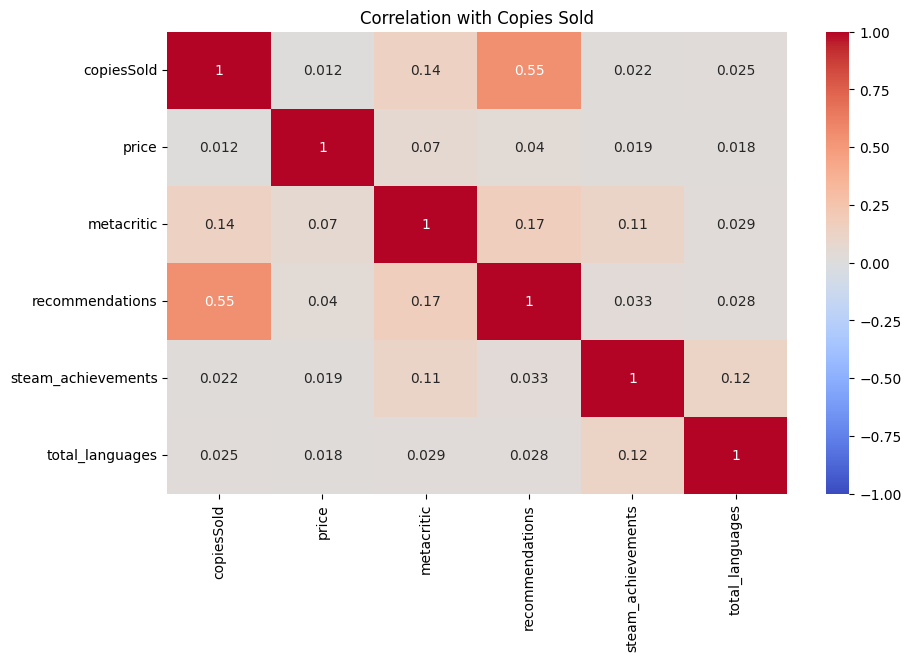

In [ ]:
# Heatmap showing the correlation matrix between 'copiesSold' and selected numerical features

corr = df[['copiesSold', 'price', 'metacritic', 'recommendations', 'steam_achievements', 'total_languages']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Copies Sold')
plt.show()

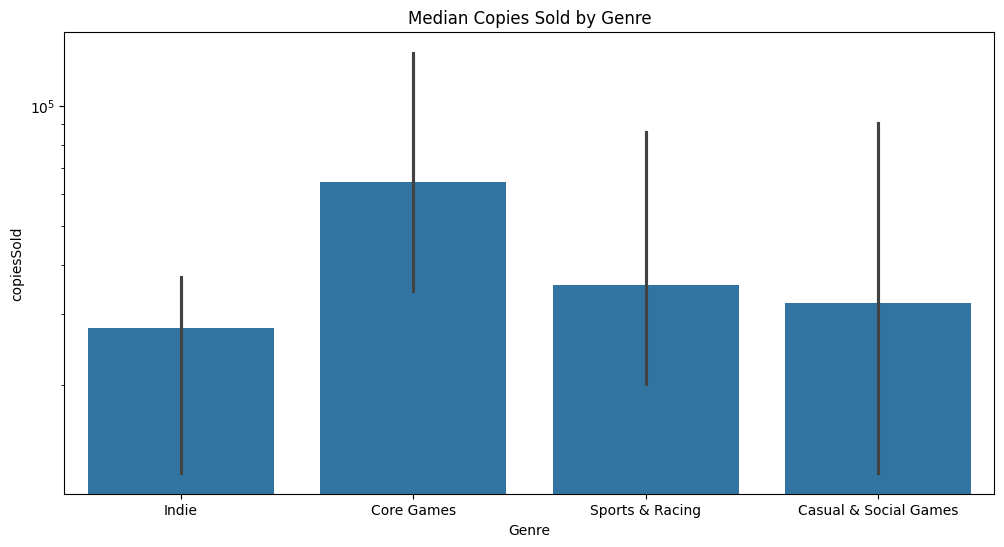

In [ ]:
# Bar chart of the median copies sold per genre

genres = ['Indie', 'Core Games', 'Sports & Racing', 'Casual & Social Games']
genre_sales = df.groupby(genres)['copiesSold'].mean().reset_index()
genre_sales = genre_sales.melt(id_vars='copiesSold', var_name='Genre', value_name='Has_Genre')
genre_sales = genre_sales[genre_sales['Has_Genre'] == 1]

plt.figure(figsize=(12, 6))
sns.barplot(x='Genre', y='copiesSold', data=genre_sales, estimator=np.median)
plt.title('Median Copies Sold by Genre')
plt.yscale('log')
plt.show()

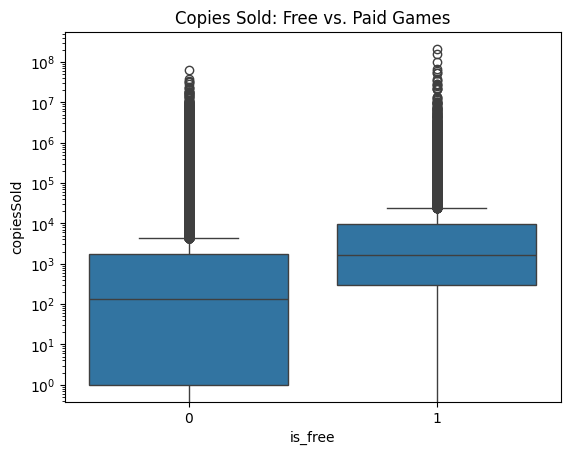

In [ ]:
# Boxplot comparing copies sold between free and paid games

sns.boxplot(x='is_free', y='copiesSold', data=df)
plt.title('Copies Sold: Free vs. Paid Games')
plt.yscale('log')
plt.show()

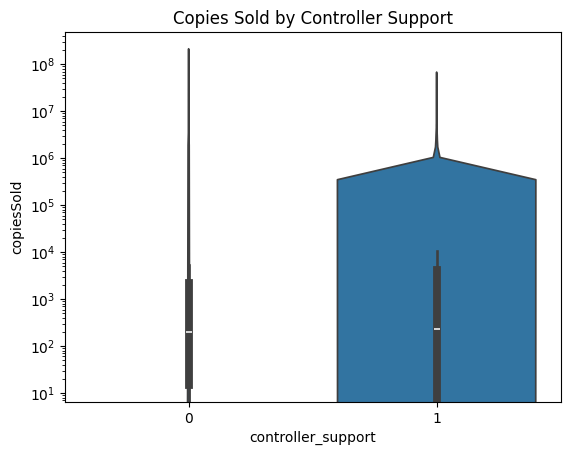

In [ ]:
# Violin plot showing the distribution of copies sold grouped by controller support status

sns.violinplot(x='controller_support', y='copiesSold', data=df)
plt.title('Copies Sold by Controller Support')
plt.yscale('log')
plt.show()

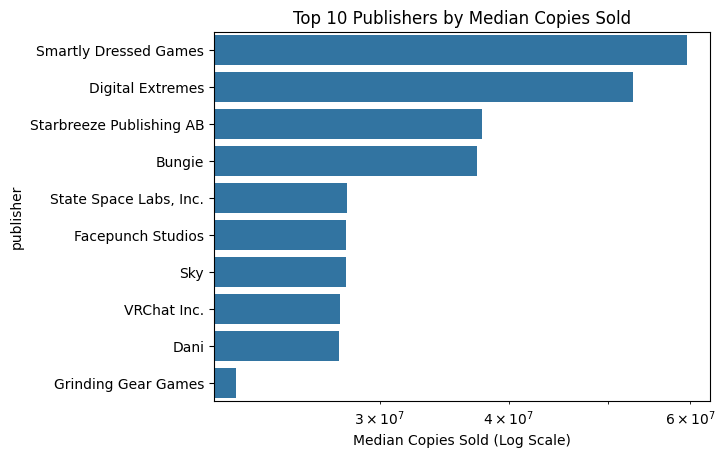

In [ ]:
# Horizontal bar chart of the top 10 publishers by median copies sold

top_publishers = df.groupby('publisher')['copiesSold'].median().sort_values(ascending=False).head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('Top 10 Publishers by Median Copies Sold')
plt.xlabel('Median Copies Sold (Log Scale)')
plt.xscale('log')
plt.show()

In [ ]:
# Top 10 best-selling games along with their price, metacritic score, and publisher

top_games = df.nlargest(10, 'copiesSold')[['name_info', 'copiesSold', 'price', 'metacritic', 'publisher']]
print("Top 10 Best-Selling Games:")
print(top_games.to_string(index=False))

Top 10 Best-Selling Games:
          name_info  copiesSold  price  metacritic                publisher
             Dota 2 212896574.0   0.00          90                    Valve
PUBG: BATTLEGROUNDS 161971233.0   0.00           0            KRAFTON, Inc.
    Team Fortress 2  99060457.0   0.00          92                    Valve
      Apex Legends™  67554185.0   0.00          88          Electronic Arts
      Left 4 Dead 2  63975495.0  10.53          89                    Valve
           Unturned  59633334.0   0.00           0    Smartly Dressed Games
          Crab Game  54807548.0   0.00           0                     Dani
           Warframe  52803785.0   0.00          69         Digital Extremes
           PAYDAY 2  37690350.0   9.99          79 Starbreeze Publishing AB
          Destiny 2  37259315.0   0.00          83                   Bungie


# Feature Engineering

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   steam_id               78101 non-null  object 
 1   name_info              78086 non-null  object 
 2   metacritic             78101 non-null  int64  
 3   steam_achievements     78101 non-null  int64  
 4   steam_trading_cards    78101 non-null  int64  
 5   workshop_support       78101 non-null  int64  
 6   genres                 78101 non-null  object 
 7   achievements_total     78101 non-null  int64  
 8   release_date           77953 non-null  object 
 9   coming_soon            78101 non-null  float64
 10  support_windows        78101 non-null  int64  
 11  support_mac            78101 non-null  int64  
 12  support_linux          78101 non-null  int64  
 13  has_dlc                78101 non-null  int64  
 14  has_demo               78101 non-null  int64  
 15  pub

In [ ]:
def compute_game_age(df):
    df = df.copy()
    current_year = datetime.now().year
    df['standardized_date'] = pd.to_datetime(df['standardized_date'], errors='coerce')
    df['game_age'] = df['standardized_date'].apply(
        lambda x: current_year - x.year if pd.notna(x) else None
    )
    df['game_age'] = df['game_age'].fillna(df['game_age'].median())
    return df

In [ ]:
def compute_publisher_developer_popularity(df, publisher_avg_recs=None, developer_avg_recs=None,
                                          publisher_avg_price=None, developer_avg_price=None):
    df = df.copy()
    # Count number of games per publisher and developer
    publisher_counts = df['publisher'].value_counts().to_dict()
    developer_counts = df['developer'].value_counts().to_dict()
    df['publisher_games_count'] = df['publisher'].map(publisher_counts).fillna(1)
    df['developer_games_count'] = df['developer'].map(developer_counts).fillna(1)

    # Compute or apply average recommendations
    if publisher_avg_recs is None:
        publisher_avg_recs = df.groupby('publisher')['recommendations'].mean().to_dict()
        developer_avg_recs = df.groupby('developer')['recommendations'].mean().to_dict()
    df['publisher_avg_recs'] = df['publisher'].map(publisher_avg_recs).fillna(df['recommendations'].mean())
    df['developer_avg_recs'] = df['developer'].map(developer_avg_recs).fillna(df['recommendations'].mean())

    # Compute or apply average price
    if publisher_avg_price is None:
        publisher_avg_price = df.groupby('publisher')['price'].mean().to_dict()
        developer_avg_price = df.groupby('developer')['price'].mean().to_dict()
    df['publisher_avg_price'] = df['publisher'].map(publisher_avg_price).fillna(df['price'].mean())
    df['developer_avg_price'] = df['developer'].map(developer_avg_price).fillna(df['price'].mean())

    return df, publisher_avg_recs, developer_avg_recs, publisher_avg_price, developer_avg_price

In [ ]:
def compute_price_recommendation_ratio(df):
    df = df.copy()
    df['price_recommendation_ratio'] = df['recommendations'] / (df['price'] + 1)  # Add 1 to avoid division by zero
    df['price_recommendation_ratio'] = df['price_recommendation_ratio'].fillna(0)
    return df

In [ ]:
def create_genre_interactions(df):
    df = df.copy()
    key_genres = ['Indie', 'Core Games', 'Casual & Social Games']
    for genre in key_genres:
        if genre in df.columns:
            df[f'{genre}_price'] = df[genre] * df['price']
            df[f'{genre}_languages'] = df[genre] * df['total_languages']
    return df

In [ ]:
# new column contains 0/1 if this publisher from top 10 according to mean of copiesSold
def create_top_publisher_feature(df, top_publishers=None):
    df = df.copy()
    if top_publishers is None:
        # During training, compute top publishers
        top_publishers = df.groupby('publisher')['copiesSold'].median().sort_values(ascending=False).head(10).index
        df['is_top_publisher'] = df['publisher'].isin(top_publishers).astype(int)
        return df, top_publishers
    else:
        # During validation/test, use provided top publishers
        df['is_top_publisher'] = df['publisher'].isin(top_publishers).astype(int)
        return df

In [ ]:
def compute_multi_platform_support(df):
    df = df.copy()
    df['non_windows_platforms'] = df[['support_mac', 'support_linux']].sum(axis=1)
    return df

In [ ]:
def compute_additional_features(df, genre_scores=None):
    df = df.copy()
    # Game age bins
    # Replace negative or invalid ages with NaN
    df['game_age_clean'] = df['game_age'].apply(lambda x: x if x >= 0 else np.nan)

    #fill nulls
    mode_age = df['game_age_clean'].mode()
    df['game_age_clean'] = df['game_age_clean'].fillna(mode_age)

    # Define bins and labels
    bins = [0, 1, 3, 6, 10, 20, float('inf')]
    labels = ['new', 'recent', 'established', 'veteran', 'classic', 'retro']

    # Apply binning
    df['game_age_bin'] = pd.cut(df['game_age_clean'], bins=bins, labels=labels, include_lowest=True)

    # One-hot encode the bins
    df = pd.get_dummies(df, columns=['game_age_bin'], prefix='age_bin')

    return df

    # Recommendations-to-languages ratio
    df['recs_to_languages_ratio'] = df['recommendations'] / (df['total_languages'] + 1)  # Add 1 to avoid division by zero
    df['recs_to_languages_ratio'] = df['recs_to_languages_ratio'].fillna(0)

    # Genre popularity score
    key_genres = ['Indie', 'Core Games', 'Casual & Social Games']
    if genre_scores is None:
        genre_scores = {}
        for genre in key_genres:
            if genre in df.columns:
                genre_scores[genre] = df[df[genre] == 1]['recommendations'].mean() if df[genre].sum() > 0 else 0
    df['genre_popularity_score'] = df[key_genres].apply(
        lambda x: sum(genre_scores.get(genre, 0) for genre in key_genres if x[genre] == 1), axis=1
    )

    # Free game indicator
    df['is_free_game'] = (df['price'] == 0).astype(int)

    return df, genre_scores

In [ ]:
# Feature Engineering Function
def feature_eng(df, top_publishers=None, publisher_avg_recs=None, developer_avg_recs=None,
                publisher_avg_price=None, developer_avg_price=None, genre_scores=None):
    df = compute_game_age(df)
    df, publisher_avg_recs, developer_avg_recs, publisher_avg_price, developer_avg_price = compute_publisher_developer_popularity(
        df, publisher_avg_recs, developer_avg_recs, publisher_avg_price, developer_avg_price
    )
    df = compute_price_recommendation_ratio(df)
    df = create_genre_interactions(df)
    if top_publishers is None:
        df, top_publishers = create_top_publisher_feature(df)
    else:
        df = create_top_publisher_feature(df, top_publishers=top_publishers)
    df = compute_multi_platform_support(df)
    df = compute_additional_features(df, genre_scores)
    return df, {
        'top_publishers': top_publishers,
        'publisher_avg_recs': publisher_avg_recs,
        'developer_avg_recs': developer_avg_recs,
        'publisher_avg_price': publisher_avg_price,
        'developer_avg_price': developer_avg_price
    }

In [ ]:
CopyDF = df.copy()
CopyDF, precomputed = feature_eng(CopyDF)
CopyDF.columns

Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass', 'standardized_date', 'categories',
       'total_languages', 'Casual & Social Games', 'Core Games',
       'Creative Tools', 'Education & Training', 'Indie', 'Mature Content',
       'Productivity Tools', 'Sports & Racing', 'Uncategorized', 'game_age',
       'publisher_games_count', 'developer_games_count', 'publisher_avg_recs',
       'developer_avg_recs', 'publisher_avg_price', 'developer_avg_price',
       'price_recommendation_ratio', 'Indie_price', 'Indie_languages',
       'Core Games_price', 'Core Games_languages',
       'Ca

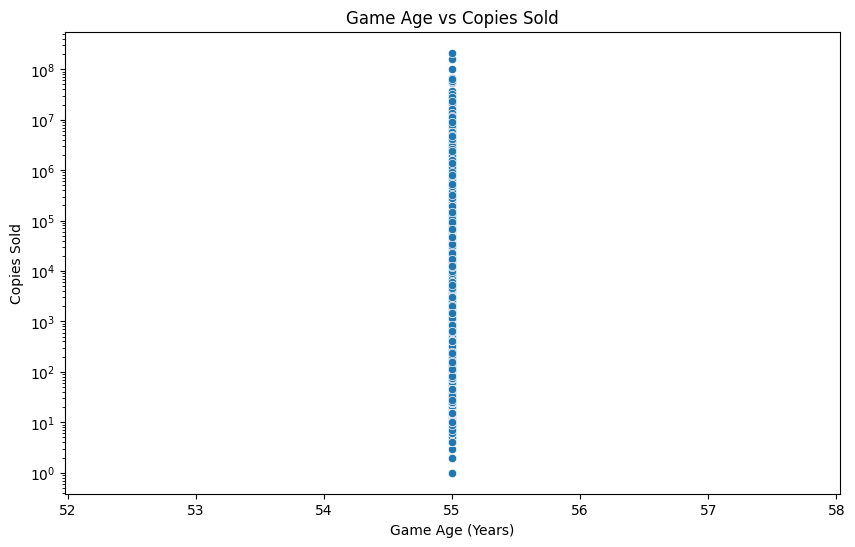

In [ ]:
# Scatter plot of game_age vs copiesSold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='game_age', y='copiesSold', data=CopyDF)
plt.title('Game Age vs Copies Sold')
plt.xlabel('Game Age (Years)')
plt.ylabel('Copies Sold')
plt.yscale('log')
plt.show()

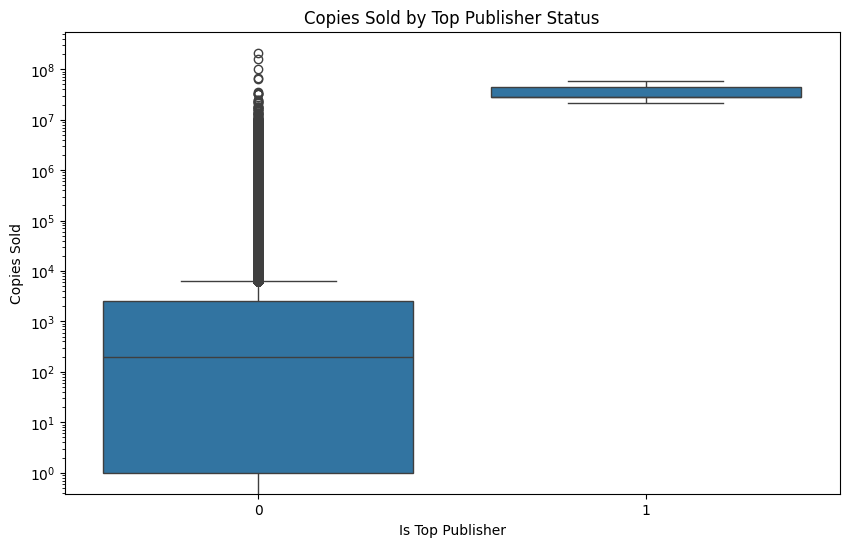

In [ ]:
# Boxplot of copiesSold by is_top_publisher
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_top_publisher', y='copiesSold', data=CopyDF)
plt.title('Copies Sold by Top Publisher Status')
plt.xlabel('Is Top Publisher')
plt.ylabel('Copies Sold')
plt.yscale('log')
plt.show()

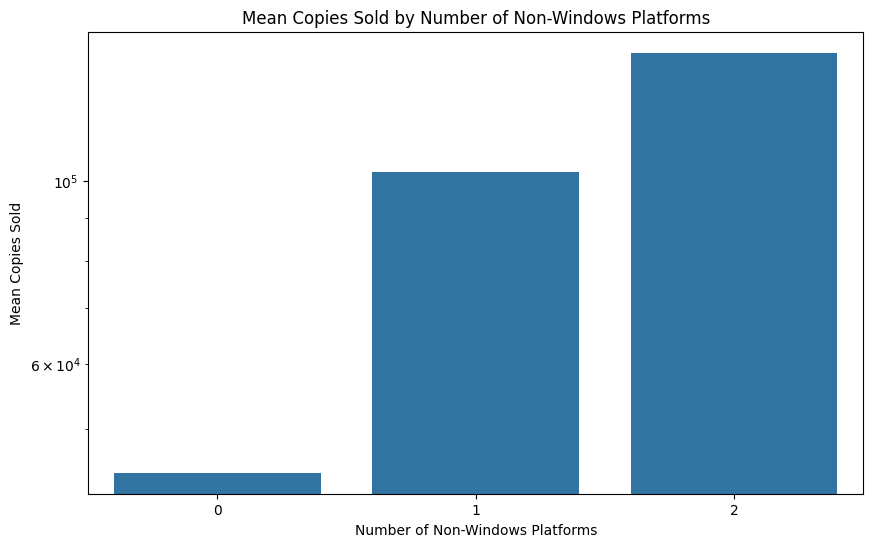

In [ ]:
# Bar chart of mean copiesSold by non_windows_platforms
platform_sales = CopyDF.groupby('non_windows_platforms')['copiesSold'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='non_windows_platforms', y='copiesSold', data=platform_sales)
plt.title('Mean Copies Sold by Number of Non-Windows Platforms')
plt.xlabel('Number of Non-Windows Platforms')
plt.ylabel('Mean Copies Sold')
plt.yscale('log')
plt.show()

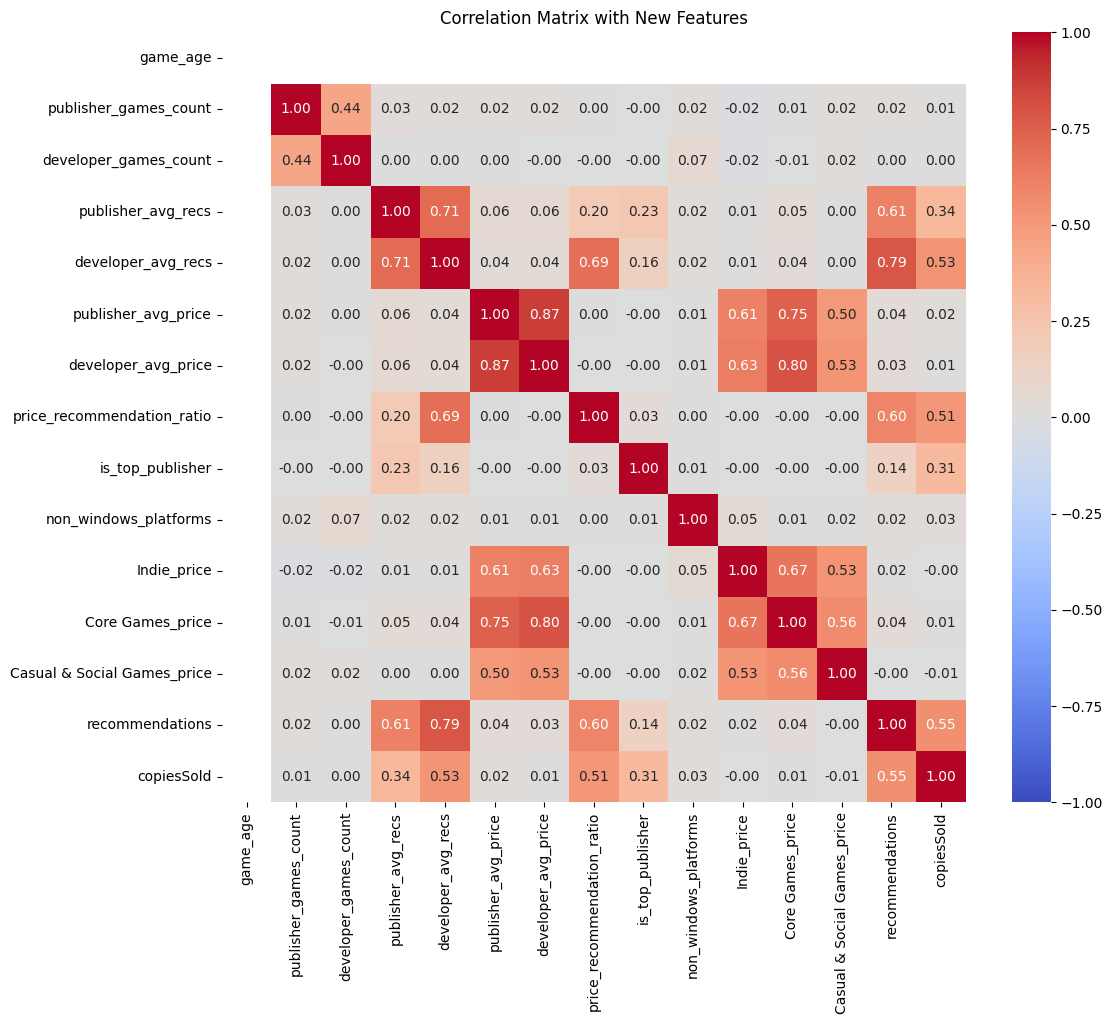

In [ ]:
# Correlation heatmap with new features
new_features = ['game_age', 'publisher_games_count', 'developer_games_count',
                'publisher_avg_recs', 'developer_avg_recs', 'publisher_avg_price', 'developer_avg_price',
                'price_recommendation_ratio', 'is_top_publisher', 'non_windows_platforms',
                'recs_to_languages_ratio', 'genre_popularity_score', 'is_free_game',
                'Indie_price', 'Core Games_price', 'Casual & Social Games_price',
                'recommendations', 'copiesSold']
# Filter out features not in CopyDF
new_features = [f for f in new_features if f in CopyDF.columns]
corr = CopyDF[new_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix with New Features')
plt.show()

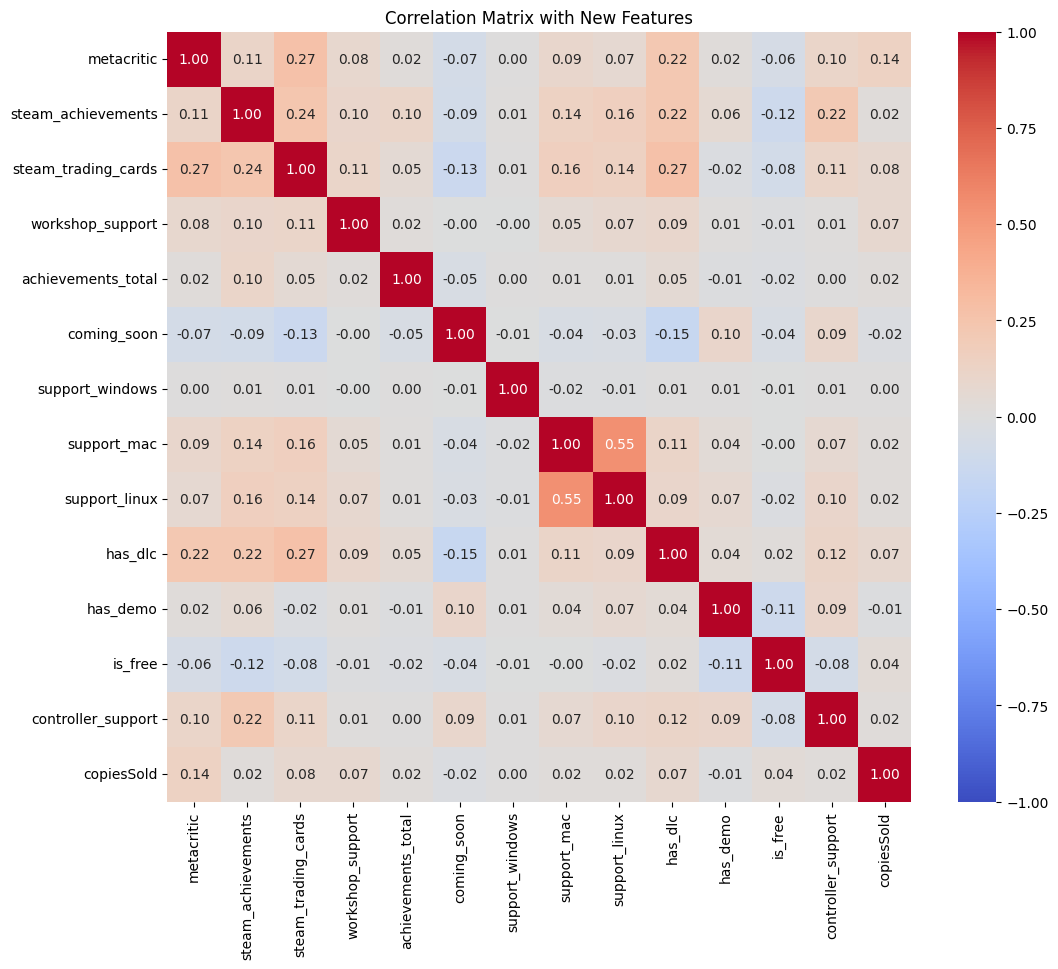

In [ ]:
# Correlation heatmap with new features
new_features = ['metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support',
       'achievements_total', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo',
       'is_free', 'controller_support', 'copiesSold']
# Filter out features not in CopyDF
new_features = [f for f in new_features if f in CopyDF.columns]
corr = CopyDF[new_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix with New Features')
plt.show()

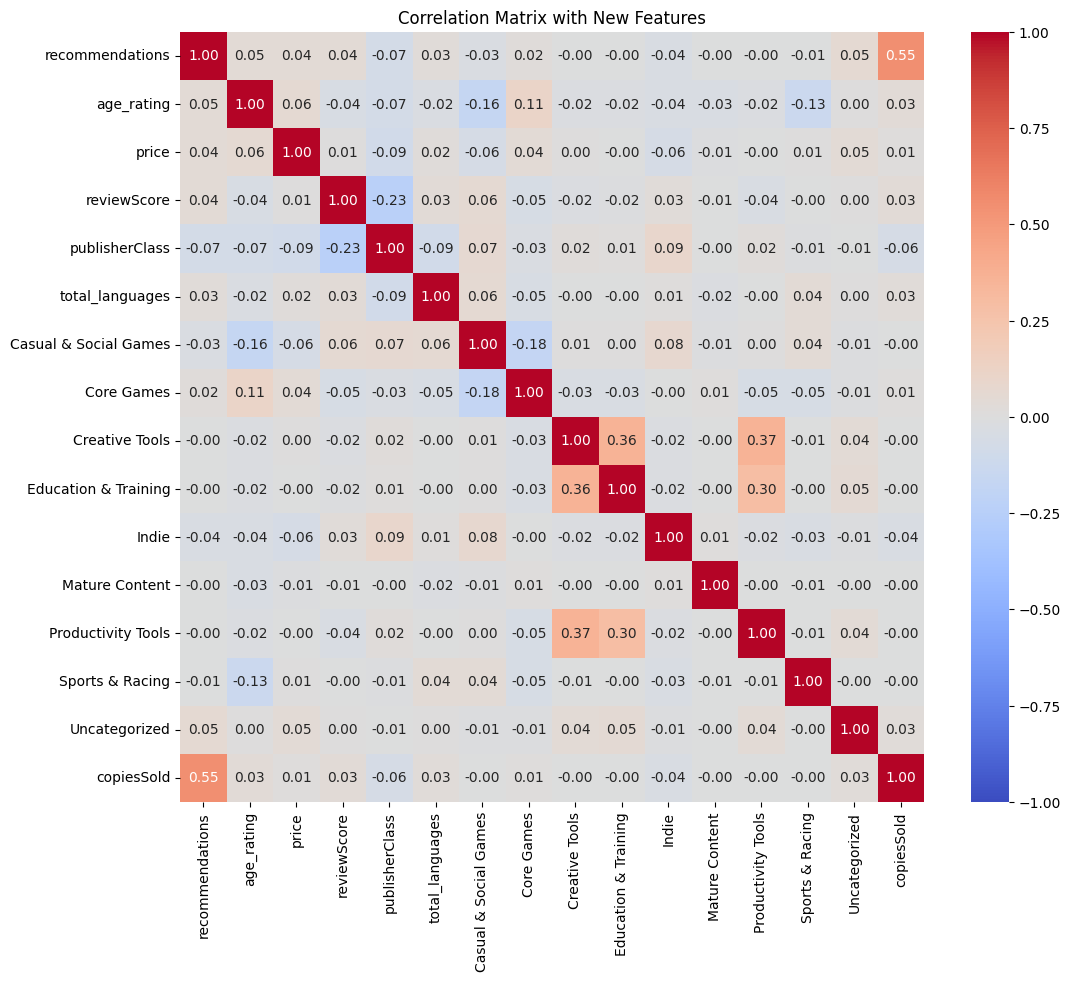

In [ ]:
# Correlation heatmap with new features
new_features = ['recommendations', 'age_rating', 'price',
                'reviewScore', 'publisherClass',
                'total_languages', 'Casual & Social Games', 'Core Games',
                'Creative Tools', 'Education & Training', 'Indie', 'Mature Content',
                'Productivity Tools', 'Sports & Racing', 'Uncategorized','copiesSold']
# Filter out features not in CopyDF
new_features = [f for f in new_features if f in CopyDF.columns]
corr = CopyDF[new_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix with New Features')
plt.show()

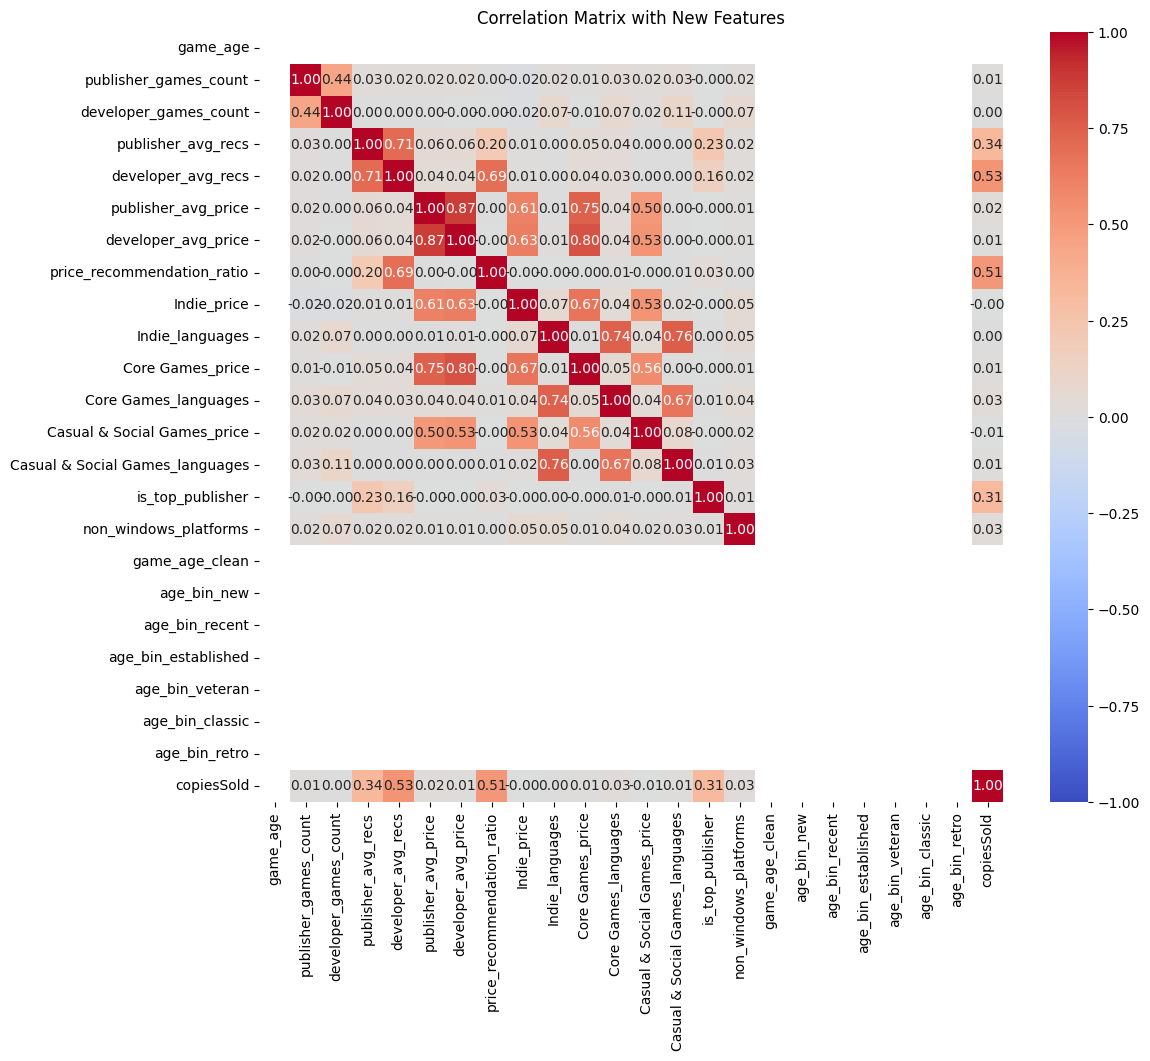

In [ ]:
# Correlation heatmap with new features
new_features = ['standardized_dates', 'game_age', 'publisher_games_count',
       'developer_games_count', 'publisher_avg_recs', 'developer_avg_recs',
       'publisher_avg_price', 'developer_avg_price',
       'price_recommendation_ratio', 'Indie_price', 'Indie_languages',
       'Core Games_price', 'Core Games_languages',
       'Casual & Social Games_price', 'Casual & Social Games_languages',
       'is_top_publisher', 'non_windows_platforms', 'game_age_clean',
       'age_bin_new', 'age_bin_recent', 'age_bin_established',
       'age_bin_veteran', 'age_bin_classic', 'age_bin_retro', 'copiesSold']
# Filter out features not in CopyDF
new_features = [f for f in new_features if f in CopyDF.columns]
corr = CopyDF[new_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix with New Features')
plt.show()

In [ ]:
#From all of the above the new features would be:
# metacritic, recomendations, publisher_avg_recs, developer_avg_recs, price_recommendation_ratio, is_top_publisher, recs_to_languages_ratio

# Feature Selection

In [ ]:
from sklearn.feature_selection import f_regression
from scipy.stats import kendalltau

def select_features(X, y, f_thresh=150, tau_thresh=0.2, corr_thresh=0.2):
    X = X.copy()
    y = y.copy()

    # --- F-score ---
    f_scores, f_pvals = f_regression(X.fillna(0), y.fillna(0))
    f_df = pd.DataFrame({'feature': X.columns, 'f_score': f_scores})
    selected_f = set(f_df[f_df['f_score'] >= f_thresh]['feature'])

    # --- Kendall's Tau ---
    taus, tau_signs = [], []
    for col in X.columns:
        mask = X[col].notna() & y.notna()
        tau, _ = kendalltau(X.loc[mask, col], y.loc[mask]) if mask.sum() > 0 else (0, 1)
        taus.append(tau)
        tau_signs.append('positive' if tau > 0 else 'negative' if tau < 0 else 'neutral')
    tau_df = pd.DataFrame({'feature': X.columns, 'tau': taus, 'abs_tau': np.abs(taus), 'tau_sign': tau_signs})
    selected_tau = set(tau_df[tau_df['abs_tau'] >= tau_thresh]['feature'])

    # --- Pearson Correlation ---
    corr_series = X.corrwith(y)
    corr_df = pd.DataFrame({
        'feature': X.columns,
        'corr': corr_series,
        'abs_corr': corr_series.abs(),
        'corr_sign': ['positive' if c > 0 else 'negative' if c < 0 else 'neutral' for c in corr_series]
    })
    selected_corr = set(corr_df[corr_df['abs_corr'] >= corr_thresh]['feature'])

    # --- Combine selected features ---
    selected = selected_f | selected_tau | selected_corr
    selected = sorted(list(selected))

    # --- Annotate signs ---
    signed_features = []
    for feature in selected:
        corr_row = corr_df[corr_df['feature'] == feature]
        tau_row = tau_df[tau_df['feature'] == feature]
        sign_corr = corr_row['corr_sign'].values[0] if not corr_row.empty else 'unknown'
        sign_tau = tau_row['tau_sign'].values[0] if not tau_row.empty else 'unknown'
        signed_features.append((feature, sign_corr, sign_tau))

    # --- Split by sign ---
    positive_features = [f for f, sc, st in signed_features if sc == 'positive' or st == 'positive']
    negative_features = [f for f, sc, st in signed_features if sc == 'negative' or st == 'negative']

    return {
        'selected_features': selected,
        'positive_features': sorted(set(positive_features)),
        'negative_features': sorted(set(negative_features)),
        'f_df': f_df.sort_values('f_score', ascending=False),
        'tau_df': tau_df.sort_values('abs_tau', ascending=False),
        'corr_df': corr_df.sort_values('abs_corr', ascending=False)
    }

In [ ]:
X = CopyDF.select_dtypes(include='number').drop(columns=['copiesSold'])
y = CopyDF['copiesSold']

result = select_features(X, y)

print("🔹 Selected Features:", result['selected_features'])
print("🟢 Positive Features:", result['positive_features'])
print("🔴 Negative Features:", result['negative_features'])

# Optionally check the stats tables
result['f_df'].head()
result['tau_df'].head()
result['corr_df'].head()

🔹 Selected Features: ['achievements_total', 'coming_soon', 'developer_avg_recs', 'has_dlc', 'is_top_publisher', 'metacritic', 'price_recommendation_ratio', 'publisherClass', 'publisher_avg_recs', 'publisher_games_count', 'recommendations', 'reviewScore', 'steam_trading_cards', 'workshop_support']
🟢 Positive Features: ['achievements_total', 'developer_avg_recs', 'has_dlc', 'is_top_publisher', 'metacritic', 'price_recommendation_ratio', 'publisher_avg_recs', 'publisher_games_count', 'recommendations', 'reviewScore', 'steam_trading_cards', 'workshop_support']
🔴 Negative Features: ['coming_soon', 'publisherClass']


,feature,corr,abs_corr,corr_sign
recommendations,recommendations,0.554273,0.554273,positive
developer_avg_recs,developer_avg_recs,0.527070,0.527070,positive
price_recommendation_ratio,price_recommendation_ratio,0.512103,0.512103,positive
publisher_avg_recs,publisher_avg_recs,0.335040,0.335040,positive
is_top_publisher,is_top_publisher,0.313721,0.313721,positive


# Apply pipeline to Validation and Test data

In [ ]:
val_df = pipeline.transform(val_df)
test_df = pipeline.transform(test_df)

# Modelling

In [ ]:
(val_df.isnull().sum()/len(val_df))*100

,0
steam_id,0.000000
name_info,0.017886
metacritic,0.000000
steam_achievements,0.000000
steam_trading_cards,0.000000
workshop_support,0.000000
genres,0.000000
achievements_total,0.000000
release_date,0.202707
coming_soon,0.000000


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

missing_percentage = (CopyDF.isnull().sum() / len(CopyDF)) * 100

print(missing_percentage)

steam_id                            0.000000
name_info                           0.019206
metacritic                          0.000000
steam_achievements                  0.000000
steam_trading_cards                 0.000000
workshop_support                    0.000000
genres                              0.000000
achievements_total                  0.000000
release_date                        0.189498
coming_soon                         0.000000
support_windows                     0.000000
support_mac                         0.000000
support_linux                       0.000000
has_dlc                             0.000000
has_demo                            0.000000
publisher                           0.092188
developer                           0.011524
is_free                             0.000000
controller_support                  0.000000
recommendations                     0.000000
age_rating                          0.000000
languages_clean_str                 0.000000
price     

In [ ]:
# Use CopyDF which already has the engineered features
selected_features2 = [
    'achievements_total', 'coming_soon', 'developer_avg_recs', 'game_age',
    'has_dlc', 'is_top_publisher', 'metacritic', 'price_recommendation_ratio', 'publisher_avg_recs',
    'publisher_games_count', 'recommendations', 'reviewScore',
    'steam_trading_cards', 'workshop_support'
]
selected_features = [
'metacritic', 'recommendations', 'publisher_avg_recs', 'developer_avg_recs', 'price_recommendation_ratio', 'is_top_publisher'
]
# Drop unnecessary columns (also from CopyDF, not df)
columns_to_drop = [
    'copiesSold', 'steam_id', 'name_info', 'publisher', 'developer',
    'languages_clean_str', 'standardized_date'
]

# Training set
X_train = CopyDF.drop(columns=columns_to_drop)
X_train = X_train[selected_features]
y_train = CopyDF['copiesSold']

def ensure_datetime(df, date_col='standardized_date'):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    return df

val_df = ensure_datetime(val_df)
test_df = ensure_datetime(test_df)

# Validation and test sets must also be engineered with same logic
val_df_eng, _ = feature_eng(val_df.copy(), **precomputed)
test_df_eng, _ = feature_eng(test_df.copy(), **precomputed)

X_val = val_df_eng.drop(columns=columns_to_drop)
X_val = X_val[selected_features]
y_val = val_df_eng['copiesSold']

X_test = test_df_eng.drop(columns=columns_to_drop)
X_test = X_test[selected_features]
y_test = test_df_eng['copiesSold']

In [ ]:
df.columns

Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass', 'standardized_date', 'categories',
       'total_languages', 'Casual & Social Games', 'Core Games',
       'Creative Tools', 'Education & Training', 'Indie', 'Mature Content',
       'Productivity Tools', 'Sports & Racing', 'Uncategorized',
       'standardized_dates'],
      dtype='object')

In [ ]:
val_df.columns

Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass', 'standardized_date', 'categories',
       'total_languages', 'Casual & Social Games', 'Core Games',
       'Creative Tools', 'Education & Training', 'Indie', 'Mature Content',
       'Productivity Tools', 'Sports & Racing', 'Uncategorized'],
      dtype='object')

In [ ]:
# df.drop(columns=['standardized_dates'], inplace = True)

In [ ]:

selected_features2 = [
    'achievements_total', 'coming_soon', 'developer_avg_recs', 'game_age',
    'has_dlc', 'is_top_publisher', 'metacritic', 'price_recommendation_ratio', 'publisher_avg_recs',
    'publisher_games_count', 'recommendations', 'reviewScore',
    'steam_trading_cards', 'workshop_support'
]
selected_features = [
'metacritic', 'recommendations', 'publisher_avg_recs', 'developer_avg_recs', 'price_recommendation_ratio', 'is_top_publisher'
]
columns_to_drop = ['copiesSold', 'steam_id', 'name_info', 'publisher', 'developer',
                'languages_clean_str', 'standardized_date', 'genres','categories', 'release_date']

X_train = df.drop(columns=columns_to_drop)
X_train = X_train
y_train = df['copiesSold']

def ensure_datetime(df, date_col='standardized_date'):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    return df

val_df = ensure_datetime(val_df)
test_df = ensure_datetime(test_df)

# Validation and test sets must also be engineered with same logic
val_df_eng, _ = feature_eng(val_df.copy(), **precomputed)
test_df_eng, _ = feature_eng(test_df.copy(), **precomputed)

X_val = val_df.drop(columns=columns_to_drop)
X_val = X_val
y_val = val_df['copiesSold']

X_test = test_df.drop(columns=columns_to_drop)
X_test = X_test
y_test = test_df['copiesSold']

In [ ]:
# Use instead of GridSearchCV
def manual_grid_search_generic(model_class, param_grid, X_train, y_train, X_val, y_val, fixed_params=None):
    from itertools import product

    best_score = -float('inf')
    best_model = None
    best_params = None

    fixed_params = fixed_params or {}
    keys, values = zip(*param_grid.items()) if param_grid else ([], [])

    for combo in product(*values) if keys else [()]:
        params = dict(zip(keys, combo)) if keys else {}
        full_params = {**fixed_params, **params}
        model = model_class(**full_params)
        model.fit(X_train, y_train)
        val_score = r2_score(y_val, model.predict(X_val))

        if val_score > best_score:
            best_score = val_score
            best_model = model
            best_params = full_params

    return best_model, best_params, best_score

results = {}

def evaluate_sets(model, X_train, y_train, X_val, y_val, X_test, y_test, name):
  results[name] = {}  # Create nested dict for this model
  for X, y, label in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['Train', 'Validation', 'Test']):
      y_pred = model.predict(X)
      r2 = r2_score(y, y_pred)
      results[name][f"{label} R²"] = r2
      print(f"{label} Accuracy (R²): {r2 * 100:.2f}%")
  print("=" * 48)
  return results[name]['Train R²'], results[name]['Validation R²'], results[name]['Test R²']

def print_accuracy_summary(model_name, train_r2, val_r2, test_r2, results_dict):
  results_dict[model_name] = {
      'Train R²': train_r2,
      'Validation R²': val_r2,
      'Test R²': test_r2
  }

  print(f"📊 Accuracy Summary for {model_name}")
  print(f"Train R²:       {train_r2:.4f} ({train_r2 * 100:.2f}%)")
  print(f"Validation R²:  {val_r2:.4f} ({val_r2 * 100:.2f}%)")
  print(f"Test R²:        {test_r2:.4f} ({test_r2 * 100:.2f}%)")
  print("=" * 50)

In [ ]:
import numpy as np

# Clean training set
train_mask = ~np.isnan(y_train)
X_train = X_train[train_mask]
y_train = y_train[train_mask]

# Clean validation set
val_mask = ~np.isnan(y_val)
X_val = X_val[val_mask]
y_val = y_val[val_mask]

# Clean test set
test_mask = ~np.isnan(y_test)
X_test = X_test[test_mask]
y_test = y_test[test_mask]


In [ ]:
# Linear, Lasso, Ridge Regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge

models = {
    'Linear Regression': {
        'class': LinearRegression,
        'params': {},
        'fixed': {}
    },
    'Lasso Regression': {
        'class': Lasso,
        'params': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0,100.0]},
        'fixed': {'random_state': 42}
    },
    'Ridge Regression': {
        'class': Ridge,
        'params': {'alpha': [0.001,0.01,0.1, 1.0, 10.0, 100.0]},
        'fixed': {'random_state': 42}
    },
}

results = {}

for name, model_info in models.items():
    print(f"🔍 Tuning {name}")
    best_model, best_params, best_val_r2 = manual_grid_search_generic(
        model_info['class'],
        model_info['params'],
        X_train, y_train,
        X_val, y_val,
        fixed_params=model_info.get('fixed')
    )
    print(f"Best Params: {best_params}")
    train_r2, val_r2, test_r2 = evaluate_sets(best_model, X_train, y_train, X_val, y_val, X_test, y_test, name)
    print_accuracy_summary(name, train_r2, val_r2, test_r2, results)


🔍 Tuning Linear Regression
Best Params: {}
Train Accuracy (R²): 31.37%
Validation Accuracy (R²): 94.03%
Test Accuracy (R²): 42.49%
📊 Accuracy Summary for Linear Regression
Train R²:       0.3137 (31.37%)
Validation R²:  0.9403 (94.03%)
Test R²:        0.4249 (42.49%)
🔍 Tuning Lasso Regression
Best Params: {'random_state': 42, 'alpha': 100.0}
Train Accuracy (R²): 31.37%
Validation Accuracy (R²): 94.06%
Test Accuracy (R²): 42.58%
📊 Accuracy Summary for Lasso Regression
Train R²:       0.3137 (31.37%)
Validation R²:  0.9406 (94.06%)
Test R²:        0.4258 (42.58%)
🔍 Tuning Ridge Regression
Best Params: {'random_state': 42, 'alpha': 100.0}
Train Accuracy (R²): 31.37%
Validation Accuracy (R²): 94.06%
Test Accuracy (R²): 42.60%
📊 Accuracy Summary for Ridge Regression
Train R²:       0.3137 (31.37%)
Validation R²:  0.9406 (94.06%)
Test R²:        0.4260 (42.60%)


In [ ]:
# MLP Regressor
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42)
mlp.fit(X_train, y_train)
train_r2, val_r2, test_r2 = evaluate_sets(mlp, X_train, y_train, X_val, y_val, X_test, y_test, 'MLP Regressor')

print_accuracy_summary('MLP Regressor', train_r2, val_r2, test_r2, results)

Train Accuracy (R²): 30.79%
Validation Accuracy (R²): 93.39%
Test Accuracy (R²): 51.36%
📊 Accuracy Summary for MLP Regressor
Train R²:       0.3079 (30.79%)
Validation R²:  0.9339 (93.39%)
Test R²:        0.5136 (51.36%)


In [ ]:
# CatBoost Regressor
from catboost import CatBoostRegressor

param_grid_cat = {
    'depth': [4, 6, 8 , 10],
    'learning_rate': [0.01, 0.05, 0.1,1.0],
    'iterations': [100, 200,300,400,500,600]
}

cat_model, cat_params, cat_val_r2 = manual_grid_search_generic(
    CatBoostRegressor,
    param_grid_cat,
    X_train, y_train,
    X_val, y_val,
    fixed_params={'random_state': 42, 'verbose': 0}
)
print("Best CatBoost Params:", cat_params)
train_r2, val_r2, test_r2 = evaluate_sets(cat_model, X_train, y_train, X_val, y_val, X_test, y_test, 'CatBoost')
print_accuracy_summary('CatBoost', train_r2, val_r2, test_r2, results)

Best CatBoost Params: {'random_state': 42, 'verbose': 0, 'depth': 4, 'learning_rate': 0.05, 'iterations': 600}
Train Accuracy (R²): 92.19%
Validation Accuracy (R²): 60.05%
Test Accuracy (R²): 63.75%
📊 Accuracy Summary for CatBoost
Train R²:       0.9219 (92.19%)
Validation R²:  0.6005 (60.05%)
Test R²:        0.6375 (63.75%)
